# PD Model Data Preparation

* `Default Definition`: A borrower is said to default if he/she fails to repay the debt within 45 days (say)
* PD Model must be interpretable:
    * Use Logistic Regression
    * Convert continuous variables into dummy variables

In [ ]:
%load_ext autoreload
%autoreload 2

## Change Working Directory (Google Colab)

In [ ]:
import os
os.chdir('/content/drive/MyDrive/projects/credit-risk-modelling-udemy/notebooks')
os.listdir('../')

['venv-hpx360-win',
 'data',
 'src',
 '.git',
 'requirements.txt',
 'README.md',
 'src.egg-info',
 'setup.py',
 'notebooks',
 'reports',
 'outputs',
 '.gitignore']

In [ ]:
!pip install -e ../.

Obtaining file:///content/drive/MyDrive/projects/credit-risk-modelling-udemy
  Running setup.py develop for src


## Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import src
import os
from IPython.display import display

## Load the data

In [4]:
from src.project.config import PROJECT_DIR

In [7]:
fpath = os.path.join(PROJECT_DIR, 'outputs/loan_data_general_preprocessed_nb2.pkl')
loan_data = pd.read_pickle(fpath)
loan_data.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,addr_state:IN,addr_state:IA,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:ME,addr_state:MD,addr_state:MA,addr_state:MI,addr_state:MN,addr_state:MS,addr_state:MO,addr_state:MT,addr_state:NE,addr_state:NV,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NY,addr_state:NC,addr_state:ND,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VT,addr_state:VA,addr_state:WA,addr_state:WV,addr_state:WI,addr_state:WY,addr_state:DC,initial_list_status:f,initial_list_status:w
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgrade...,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use thi...,car,bike,309xx,GA,1.00,0.0,1999-04-01,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,2001-11-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for proper...,other,personel,917xx,CA,20.00,0.0,1996-02-01,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combini...,other,Personal,972xx,OR,17.94,0.0,1996-01-01,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## loan_status

In [9]:
loan_data['loan_status'].value_counts(normalize=True)

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

* `Current`, `Fully Paid`, `In Grace Period`, `Does not meet the credit policy. Status:Fully Paid`
    * `Good` Loans - Non-Default
* `Charged Off`, `Late (31-120 days)`, `Late (16-30 days)`, `Default`, `Does not meet the credit policy. Status:Charged Off`
    * `Bad` Loans - Default


In [10]:
good_loan_cats = ['Current', 'Fully Paid', 'In Grace Period', 'Does not meet the credit policy. Status:Fully Paid']
loan_data['good_bad_loan'] = loan_data['loan_status'].isin(good_loan_cats).astype('Int64')
loan_data['good_bad_loan'].value_counts(normalize=True)

1    0.888081
0    0.111919
Name: good_bad_loan, dtype: float64

* The Dataset is highly imbalanced with only 11% defaults
* Assigning 1 to a good loan is done purposely to ensure that the weights associated with each feature when higher (positive), should imply a positive association with being a good loan
    * and hence in turn imply a higher credit score

## Splitting into `Train` and `Test` sets

In [11]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

In [12]:
dfX_train, dfX_test, y_train, y_test = train_test_split(loan_data.drop(['good_bad_loan'], axis=1), loan_data['good_bad_loan'], test_size=0.2, random_state=RANDOM_STATE)

In [13]:
print('Train size:', len(y_train), 'Test size:', len(y_test))

Train size: 373028 Test size: 93257


In [202]:
DATA_STORE = {'train': [dfX_train, y_train], 'test': [dfX_test, y_test]}

## Preparing Data

In [203]:
SUBSET_TYPE = 'test'

In [204]:
df = pd.concat([DATA_STORE[SUBSET_TYPE][0], DATA_STORE[SUBSET_TYPE][1]], axis=1)
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,addr_state:IA,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:ME,addr_state:MD,addr_state:MA,addr_state:MI,addr_state:MN,addr_state:MS,addr_state:MO,addr_state:MT,addr_state:NE,addr_state:NV,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NY,addr_state:NC,addr_state:ND,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VT,addr_state:VA,addr_state:WA,addr_state:WV,addr_state:WI,addr_state:WY,addr_state:DC,initial_list_status:f,initial_list_status:w,good_bad_loan
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,C5,Licensed vocational nurse,< 1 year,MORTGAGE,65000.0,Verified,2014-07-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,950xx,CA,9.32,0.0,2002-04-01,0.0,NaN,NaN,7.0,0.0,1208,4.3,20.0,f,0.00,0.00,38213.56000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,E4,shift manager,10+ years,MORTGAGE,60000.0,Verified,2014-10-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,472xx,IN,24.19,1.0,2003-08-01,0.0,3.0,NaN,18.0,0.0,13129,54.7,43.0,w,9214.67,9214.67,4450.12000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,C2,FastMed urgent care,1 year,MORTGAGE,175000.0,Verified,2012-06-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/06/12 > I am seeking a de...,debt_consolidation,Debt Consolidation,852xx,AZ,13.34,0.0,2002-03-01,0.0,41.0,NaN,9.0,0.0,1906,22.4,38.0,f,0.00,0.00,32388.64000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,C4,Registered Nurse,2 years,MORTGAGE,66000.0,Source Verified,2014-11-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,498xx,MI,17.69,0.0,2008-08-01,0.0,NaN,NaN,12.0,0.0,12944,74.4,31.0,w,11901.76,11901.76,4719.18000,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,A5,Courier Times,10+ years,MORTGAGE,85000.0,Verified,2013-02-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 02/06/13 > I need to cosolid...,debt_consolidation,Consolidate 2013,190xx,PA,8.30,0.0,1986-10-01,0.0,39.0,NaN,7.0,0.0,5902,67.8,20.0,f,0.00,0.00,16628.33315,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


## Weight of Evidence

* Each categorical feature is made up of several categories
* In each feature, we quantofy the ability of each category to predict the dependant variable - WoE
* We then take a weighted average of such quantified scores and judge the overall information contained in the categorical feature wrt its predictive power (for the dependant variable)

For the ith category in a categorical feature with k categories:

$WOE_{i} =  \log\frac{\%(y = 1)}{\%(y = 0)}$

* This just quantifies how a particular category can differentiate between the two categories in the dependant variable
* This is the just the log of odds if we just use the particular category to judge the quality of the loan application

Other way to look at it is, how much more differentiating information we gathered by selecting this particular category in the feature as compared to the overall differentiation present in the data:

$WOE =  \log\frac{n_{good}}{n_{bad}} - \log\frac{N_{good}}{N_{bad}}$

Then the information value $IV$ will then be just the weighted average:


$IV = \dfrac{\sum^{k}_{i=1} WOE_{i}}{k}$


* To reduce the number of predictor dummies in the statistical model, we combine categories for a feature if the WoE are very similar
    * i.e. if the categories have similar differentiating powers, we club them together
* The information value can help us preselect the top best n predictors to use in the statistical model


|    | IV              | Predictive Power           |
|---:|:----------------|:---------------------------|
|  0 | IV < 0.02       | No Predictive Power        |
|  1 | 0.02 < IV < 0.1 | Weak Predictive Power      |
|  2 | 0.1 < IV < 0.3  | Medium Predictive Power    |
|  3 | 0.3 < IV < 0.5  | Strong Predictive Power    |
|  4 | 0.5 < IV        | Suspiciously high, too good to be true |

### WoE calculation for `grade`

In [205]:
sorted(df['grade'].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [206]:
cat_feat = df['grade']

dep_feat_map = {0: 'bad', 1: 'good'}
dep_feat = df['good_bad_loan']

pos_feat = dep_feat_map[1]
neg_feat = dep_feat_map[0]

In [207]:
d = pd.concat([cat_feat, dep_feat], axis=1)
d.head()

,grade,good_bad_loan
362514,C,1
288564,E,1
213591,C,1
263083,C,1
165001,A,1


In [208]:
counts_df = d.groupby(d.columns[0], as_index=False)[d.columns[1]].count()
prop_df = d.groupby(d.columns[0], as_index=False)[d.columns[1]].mean()

In [209]:
d = pd.concat([counts_df, prop_df.iloc[:, 1:]], axis=1)
d.columns = [d.columns[0], 'n_obs', f'prop_{pos_feat}']
d

,grade,n_obs,prop_good
0,A,15108,0.961213
1,B,27199,0.921431
2,C,25048,0.880150
3,D,15390,0.840676
4,E,7145,0.800980
5,F,2699,0.769544
6,G,668,0.691617


In [210]:
d[f'prop_{neg_feat}'] = 1 - d[f'prop_{pos_feat}']
d[f'n_{pos_feat}'] = d['n_obs']*d[f'prop_{pos_feat}']
d[f'n_{neg_feat}'] = d['n_obs'] - d[f'n_{pos_feat}']
d[f'prop_n_{pos_feat}'] = d[f'n_{pos_feat}']/d[f'n_{pos_feat}'].sum()
d[f'prop_n_{neg_feat}'] = d[f'n_{neg_feat}']/d[f'n_{neg_feat}'].sum()
d['woe'] = np.log(d[f'prop_n_{pos_feat}']/d[f'prop_n_{neg_feat}'])
d = d.sort_values('woe').reset_index(drop=True)

In [211]:
d

,grade,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe
0,G,668,0.691617,0.308383,462.0,206.0,0.005578,0.019756,-1.264703
1,F,2699,0.769544,0.230456,2077.0,622.0,0.025075,0.059653,-0.866652
2,E,7145,0.800980,0.199020,5723.0,1422.0,0.069093,0.136377,-0.679963
3,D,15390,0.840676,0.159324,12938.0,2452.0,0.156199,0.235159,-0.409127
4,C,25048,0.880150,0.119850,22046.0,3002.0,0.266160,0.287906,-0.078539
5,B,27199,0.921431,0.078569,25062.0,2137.0,0.302572,0.204949,0.389558
6,A,15108,0.961213,0.038787,14522.0,586.0,0.175323,0.056200,1.137709


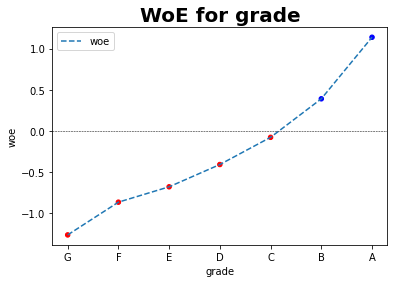

In [212]:
fig, ax = plt.subplots()
colors = (d['woe'] > 0).map({False: 'red', True: 'blue'})
d.plot(x='grade', y='woe', linestyle='--', ax=ax)
d.plot(x='grade', y='woe', ax=ax, kind='scatter', c=colors)
ax.axhline(y=0, linestyle='--', color='k', linewidth=0.5)
ax.set_title(f'WoE for {cat_feat.name}', fontdict=dict(weight='bold', size=20));

In [213]:
d[f'diff_prop_{pos_feat}'] = d[f'prop_{pos_feat}'].diff().abs()
d['diff_woe'] = d['woe'].diff().abs()
d['iv'] = (d['prop_n_good'] - d['prop_n_bad'])*d['woe']
d['iv'] = d['iv'].sum()

In [214]:
d

,grade,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,G,668,0.691617,0.308383,462.0,206.0,0.005578,0.019756,-1.264703,NaN,NaN,0.301218
1,F,2699,0.769544,0.230456,2077.0,622.0,0.025075,0.059653,-0.866652,0.077928,0.398051,0.301218
2,E,7145,0.800980,0.199020,5723.0,1422.0,0.069093,0.136377,-0.679963,0.031435,0.186689,0.301218
3,D,15390,0.840676,0.159324,12938.0,2452.0,0.156199,0.235159,-0.409127,0.039696,0.270836,0.301218
4,C,25048,0.880150,0.119850,22046.0,3002.0,0.266160,0.287906,-0.078539,0.039474,0.330588,0.301218
5,B,27199,0.921431,0.078569,25062.0,2137.0,0.302572,0.204949,0.389558,0.041281,0.468097,0.301218
6,A,15108,0.961213,0.038787,14522.0,586.0,0.175323,0.056200,1.137709,0.039782,0.748150,0.301218


In [215]:
def get_weight_of_evidence_stats(cat_feat, dep_feat, dep_feat_map, sorter_feat_func=lambda d: d['woe']):
    
    pos_feat = dep_feat_map[1]
    neg_feat = dep_feat_map[0]

    d = pd.concat([cat_feat, dep_feat], axis=1)
    counts_df = d.groupby(d.columns[0], as_index=False)[d.columns[1]].count()
    prop_df = d.groupby(d.columns[0], as_index=False)[d.columns[1]].mean()

    d = pd.concat([counts_df, prop_df.iloc[:, 1:]], axis=1)
    d.columns = [d.columns[0], 'n_obs', f'prop_{pos_feat}']

    d[f'prop_{neg_feat}'] = 1 - d[f'prop_{pos_feat}']
    d[f'n_{pos_feat}'] = d['n_obs']*d[f'prop_{pos_feat}']
    d[f'n_{neg_feat}'] = d['n_obs'] - d[f'n_{pos_feat}']
    d[f'prop_n_{pos_feat}'] = d[f'n_{pos_feat}']/d[f'n_{pos_feat}'].sum()
    d[f'prop_n_{neg_feat}'] = d[f'n_{neg_feat}']/d[f'n_{neg_feat}'].sum()
    d['woe'] = np.log(d[f'prop_n_{pos_feat}']/d[f'prop_n_{neg_feat}'])

    d['_sorter_col'] = sorter_feat_func(d)
    d = d.sort_values('_sorter_col').reset_index(drop=True).drop('_sorter_col', axis=1)

    d[f'diff_prop_{pos_feat}'] = d[f'prop_{pos_feat}'].diff().abs()
    d['diff_woe'] = d['woe'].diff().abs()
    d['iv'] = (d['prop_n_good'] - d['prop_n_bad'])*d['woe']
    d['iv'] = d['iv'].sum()

    return d

In [216]:
def plot_by_woe(woe_df, ax=None):

    if ax is None:
        fig, ax = plt.subplots()

    cat_feat_name = woe_df.columns[0]

    prop_obs = woe_df['n_obs']/woe_df['n_obs'].sum()

    ax.plot(woe_df.iloc[:, 0].to_numpy(), np.zeros(shape=woe_df.shape[0]), linewidth=0)
    colors = (woe_df['woe'] > 0).map({False: 'red', True: 'blue'})
    woe_df.plot(x=cat_feat_name, y='woe', ax=ax, kind='scatter', c=colors, s=prop_obs*1000)
    woe_df.plot(x=cat_feat_name, y='woe', linestyle='--', ax=ax)    
    ax.axhline(y=0, linestyle='--', color='k', linewidth=0.5)
    ax.set_title(f'WoE for {cat_feat_name}', fontdict=dict(weight='bold', size=20))
    ax.set_xticks(woe_df.iloc[:, 0])

    return ax

In [217]:
class WOEAnalyzer:

    def __init__(self, cat_feat, dep_feat, dep_feat_map):
        self.cat_feat = cat_feat
        self.dep_feat = dep_feat
        self.dep_feat_map = dep_feat_map

    def analyze(self, df):
        '''Calculates weight of evidence stats'''

        self.woe_df = get_weight_of_evidence_stats(df[self.cat_feat], df[self.dep_feat], self.dep_feat_map)

    
    def plot(self, woe_df=None, ax=None):
        if woe_df is None:
            woe_df = self.woe_df

        return plot_by_woe(woe_df, ax=ax)

    


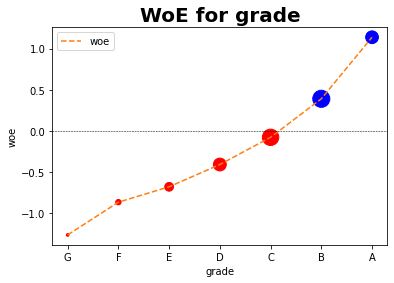

In [218]:
woe_analyzer = WOEAnalyzer('grade', 'good_bad_loan', {0: 'bad', 1: 'good'})
woe_analyzer.analyze(df)
woe_analyzer.plot()

In [219]:
woe_df = get_weight_of_evidence_stats(df['grade'], df['good_bad_loan'], {0: 'bad', 1: 'good'})
woe_df

,grade,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,G,668,0.691617,0.308383,462.0,206.0,0.005578,0.019756,-1.264703,NaN,NaN,0.301218
1,F,2699,0.769544,0.230456,2077.0,622.0,0.025075,0.059653,-0.866652,0.077928,0.398051,0.301218
2,E,7145,0.800980,0.199020,5723.0,1422.0,0.069093,0.136377,-0.679963,0.031435,0.186689,0.301218
3,D,15390,0.840676,0.159324,12938.0,2452.0,0.156199,0.235159,-0.409127,0.039696,0.270836,0.301218
4,C,25048,0.880150,0.119850,22046.0,3002.0,0.266160,0.287906,-0.078539,0.039474,0.330588,0.301218
5,B,27199,0.921431,0.078569,25062.0,2137.0,0.302572,0.204949,0.389558,0.041281,0.468097,0.301218
6,A,15108,0.961213,0.038787,14522.0,586.0,0.175323,0.056200,1.137709,0.039782,0.748150,0.301218


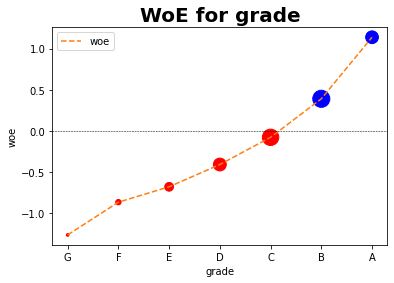

In [220]:
plot_by_woe(woe_df);

* Since the weight of evidence is drastically different for each grade, we keep these categories separate.
    * And we should definitely keep these separate anyhow, as these are external credit ratings (FICO)
* The WoE shows the expected association with the goodness of the loan, as external credit rating **G** should be a good indicator of default (hence highly negative reating)
* external credit rating **C** falls right in the middle and is a very weak indicator of the credit worthiness of the loan applicant.
* external credit rating **A** is a strong positive indicator of the credit worthiness of the loan applicant being rated highest on the FICO scale.

In [221]:
combined_cat_names = [('G',), 
                      ('F',), 
                      ('E',),
                      ('D',),
                      ('C',),
                      ('B',),
                      ('A',)]
base_col = 'grade'

In [222]:
DUMMY_VARIABLES = {}
DUMMY_VARIABLES[base_col]  = list(woe_df.iloc[:, 0])

In [223]:
DUMMY_VARIABLES

{'grade': ['G', 'F', 'E', 'D', 'C', 'B', 'A']}

## WoE analysis for `home_ownership`

In [224]:
base_col = 'home_ownership'

In [225]:
woe_df = get_weight_of_evidence_stats(df['home_ownership'], df['good_bad_loan'], {0: 'bad', 1: 'good'})
woe_df

,home_ownership,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,OTHER,45,0.777778,0.222222,35.0,10.0,0.000423,0.000959,-0.819629,NaN,NaN,0.022264
1,NONE,10,0.800000,0.200000,8.0,2.0,0.000097,0.000192,-0.686097,0.022222,0.133531,0.022264
2,RENT,37874,0.871495,0.128505,33007.0,4867.0,0.398491,0.466769,-0.158150,0.071495,0.527948,0.022264
3,OWN,8409,0.885004,0.114996,7442.0,967.0,0.089847,0.092740,-0.031695,0.013509,0.126454,0.022264
4,MORTGAGE,46919,0.902364,0.097636,42338.0,4581.0,0.511143,0.439340,0.151376,0.017359,0.183071,0.022264


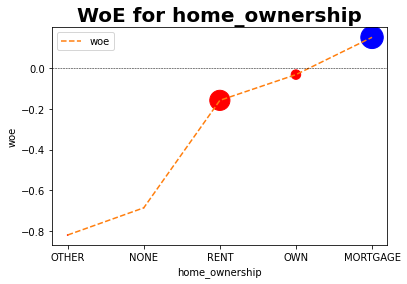

In [226]:
plot_by_woe(woe_df);

* OTHER and NONE categories, although have different WoE, but have very less number of observations. Further category ANY is only 1 data point, hence we would combine ANY with the riskiest two categories i.e. OTHER and NONE, But still as these won't be enough data points, we combined it another riskiest category i.e RENT
    * Combine to form `home_ownership:OTHER_NONE_ANY_RENT`
* RENT, OWN and MORTGAGE have sufficiently different WoE, hence we would keep them separate.

In [227]:
def combine_ohe_cat(base_col, combine, df):
    cols = [f'{base_col}:{col}' for col in combine]    
    res = sum([df[col] for col in cols])
    res.name = f'{base_col}:{"__".join(combine)}'
    return res

In [228]:
combined_cat_names = [('OTHER', 'NONE', 'ANY', 'RENT'), 
                      ('OWN',), 
                      ('MORTGAGE',)]
base_col = 'home_ownership'

In [229]:
cat_map_dict = {}

for combine_cols in combined_cat_names:
    for col in combine_cols:
        cat_map_dict[col] = '__'.join(combine_cols)

cat_map_dict

{'ANY': 'OTHER__NONE__ANY__RENT',
 'MORTGAGE': 'MORTGAGE',
 'NONE': 'OTHER__NONE__ANY__RENT',
 'OTHER': 'OTHER__NONE__ANY__RENT',
 'OWN': 'OWN',
 'RENT': 'OTHER__NONE__ANY__RENT'}

In [230]:
def map_cat(ser, map_dict):
    def_dict = {col: col for col in ser.unique()}
    map_dict = {**def_dict, **map_dict}

    return ser.map(map_dict)

df[f'{base_col}_combined'] = map_cat(df[base_col], cat_map_dict)
df[f'{base_col}_combined'].unique()

array(['MORTGAGE', 'OTHER__NONE__ANY__RENT', 'OWN'], dtype=object)

In [231]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_combined'], df['good_bad_loan'], {0: 'bad', 1: 'good'})
woe_df

,home_ownership_combined,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,OTHER__NONE__ANY__RENT,37929,0.871365,0.128635,33050.0,4879.0,0.399010,0.46792,-0.159310,NaN,NaN,0.021939
1,OWN,8409,0.885004,0.114996,7442.0,967.0,0.089847,0.09274,-0.031695,0.013639,0.127615,0.021939
2,MORTGAGE,46919,0.902364,0.097636,42338.0,4581.0,0.511143,0.43934,0.151376,0.017359,0.183071,0.021939


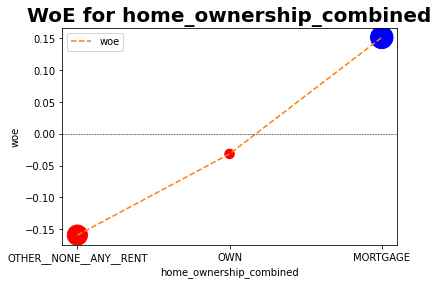

In [232]:
plot_by_woe(woe_df);

In [233]:
combined_cat_df = []
for cols in combined_cat_names:
    combined_cat = pd.DataFrame(combine_ohe_cat(base_col, cols, df))

    combined_cat_df.append(combined_cat)

combined_cat_df = pd.concat(combined_cat_df, axis=1)
combined_cat_df

,home_ownership:OTHER__NONE__ANY__RENT,home_ownership:OWN,home_ownership:MORTGAGE
362514,0,0,1
288564,0,0,1
213591,0,0,1
263083,0,0,1
165001,0,0,1
...,...,...,...
115,0,0,1
296284,1,0,0
61777,0,0,1
91763,0,0,1


In [234]:
df = pd.concat([df, combined_cat_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,addr_state:KY,addr_state:LA,addr_state:ME,addr_state:MD,addr_state:MA,addr_state:MI,addr_state:MN,addr_state:MS,addr_state:MO,addr_state:MT,addr_state:NE,addr_state:NV,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NY,addr_state:NC,addr_state:ND,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VT,addr_state:VA,addr_state:WA,addr_state:WV,addr_state:WI,addr_state:WY,addr_state:DC,initial_list_status:f,initial_list_status:w,good_bad_loan,home_ownership_combined,home_ownership:OTHER__NONE__ANY__RENT
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,C5,Licensed vocational nurse,< 1 year,MORTGAGE,65000.0,Verified,2014-07-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,950xx,CA,9.32,0.0,2002-04-01,0.0,NaN,NaN,7.0,0.0,1208,4.3,20.0,f,0.00,0.00,38213.56000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,E4,shift manager,10+ years,MORTGAGE,60000.0,Verified,2014-10-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,472xx,IN,24.19,1.0,2003-08-01,0.0,3.0,NaN,18.0,0.0,13129,54.7,43.0,w,9214.67,9214.67,4450.12000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,MORTGAGE,0
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,C2,FastMed urgent care,1 year,MORTGAGE,175000.0,Verified,2012-06-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/06/12 > I am seeking a de...,debt_consolidation,Debt Consolidation,852xx,AZ,13.34,0.0,2002-03-01,0.0,41.0,NaN,9.0,0.0,1906,22.4,38.0,f,0.00,0.00,32388.64000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,C4,Registered Nurse,2 years,MORTGAGE,66000.0,Source Verified,2014-11-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,498xx,MI,17.69,0.0,2008-08-01,0.0,NaN,NaN,12.0,0.0,12944,74.4,31.0,w,11901.76,11901.76,4719.18000,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,MORTGAGE,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,A5,Courier Times,10+ years,MORTGAGE,85000.0,Verified,2013-02-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 02/06/13 > I need to cosolid...,debt_consolidation,Consolidate 2013,190xx,PA,8.30,0.0,1986-10-01,0.0,39.0,NaN,7.0,0.0,5902,67.8,20.0,f,0.00,0.00,16628.33315,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0


In [235]:
DUMMY_VARIABLES[base_col]  = list(woe_df.iloc[:, 0])
DUMMY_VARIABLES

{'grade': ['G', 'F', 'E', 'D', 'C', 'B', 'A'],
 'home_ownership': ['OTHER__NONE__ANY__RENT', 'OWN', 'MORTGAGE']}

## addr_state

In [236]:
base_col = 'addr_state'

In [237]:
woe_df = get_weight_of_evidence_stats(df[base_col], df['good_bad_loan'], {0: 'bad', 1: 'good'})
woe_df

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,addr_state,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,NE,1,0.000000,1.000000,0.0,1.0,0.000000,0.000096,-inf,NaN,NaN,inf
1,ID,2,0.500000,0.500000,1.0,1.0,0.000012,0.000096,-2.072392,0.500000,inf,inf
2,NV,1298,0.854391,0.145609,1109.0,189.0,0.013389,0.018126,-0.302925,0.354391,1.769467,inf
3,HI,486,0.855967,0.144033,416.0,70.0,0.005022,0.006713,-0.290202,0.001576,0.012723,inf
4,AL,1182,0.867174,0.132826,1025.0,157.0,0.012375,0.015057,-0.196190,0.011207,0.094012,inf
5,FL,6426,0.867725,0.132275,5576.0,850.0,0.067319,0.081519,-0.191401,0.000551,0.004789,inf
6,NJ,3676,0.871328,0.128672,3203.0,473.0,0.038670,0.045363,-0.159644,0.003603,0.031757,inf
7,LA,1130,0.874336,0.125664,988.0,142.0,0.011928,0.013618,-0.132536,0.003009,0.027108,inf
8,DE,208,0.875000,0.125000,182.0,26.0,0.002197,0.002494,-0.126482,0.000664,0.006055,inf
9,NY,8031,0.877226,0.122774,7045.0,986.0,0.085054,0.094562,-0.105975,0.002226,0.020507,inf


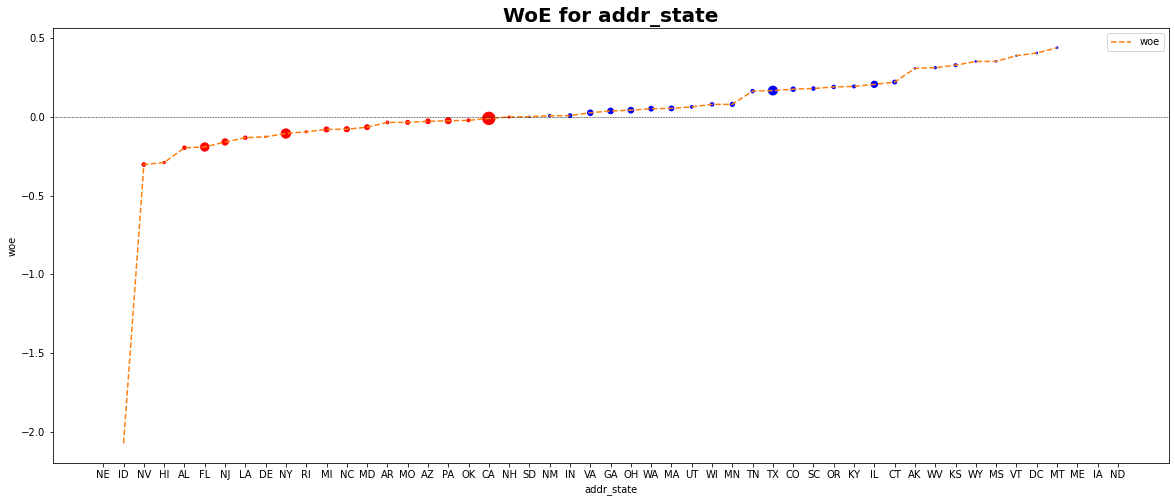

In [238]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df, ax=ax);

Let's examine the middle values separately to clearly delineate the difference between them

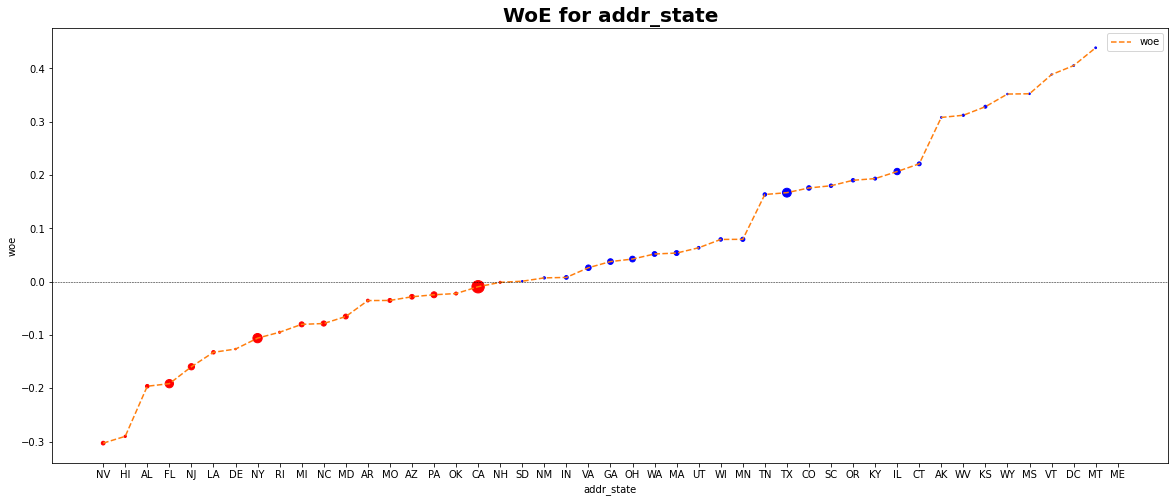

In [239]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.iloc[2:-2], ax=ax);

* Combined NE, IA, NV, and also FL, AL, HI since we would be able to increase the overal cardinality of the combined category.
* Combine last 6 states from woe_df i.e. NH, WY, DC, ME, ID, ND

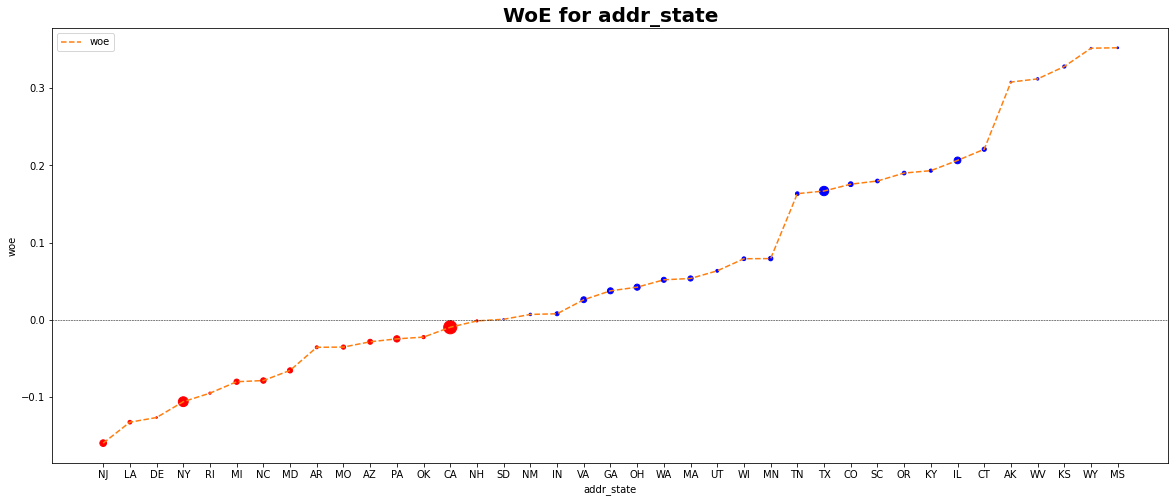

In [240]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.iloc[6:-6], ax=ax); 

* NY and CA both have high number of data points and hence will form a group of their own
* Rest categories in between can be grouped together

In [241]:
base_col = 'addr_state'
combined_cat_names = [('NE', 'IA', 'NV', 'FL', 'AL', 'HI'),
                      ('VA', 'NM'),
                      ('NY',),
                      ('TN', 'MO', 'LA', 'OK', 'NC', 'MD'),
                      ('CA',),
                      ('UT', 'NJ', 'AZ', 'KY'),
                      ('PA', 'MI', 'AR', 'OH', 'MN'),
                      ('DE', 'RI', 'MA', 'IN', 'SD'),
                      ('WA', 'GA', 'OR'),
                      ('MT', 'WI'),
                      ('TX',),
                      ('MS', 'CT', 'IL'),
                      ('KS', 'CO', 'SC', 'VT', 'AK', 'WV'),
                      ('NH', 'WY', 'DC', 'ME', 'ID', 'ND')
                      ]


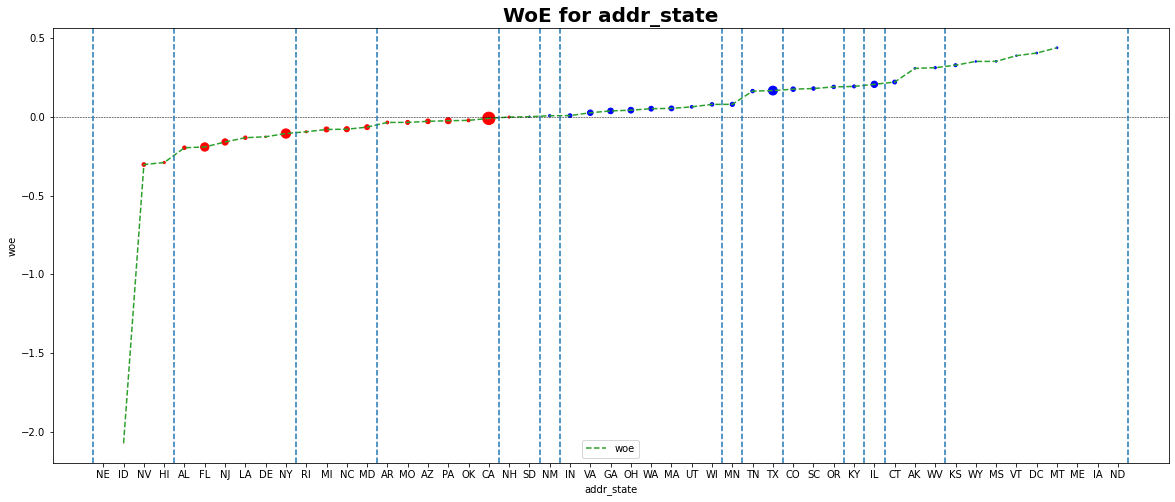

In [242]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(woe_df[base_col].to_numpy(), np.zeros(shape=woe_df.shape[0]), linewidth=0)
plot_by_woe(woe_df, ax=ax);

xticklabels = [label.get_text() for label in ax.get_xticklabels()]
xticks = ax.get_xticks()

tick_width = (xticks[0] + xticks[1])/2

ax.axvline(xticks[0] - tick_width, linestyle='--')
for combine_cols in combined_cat_names:
    idx = xticklabels.index(combine_cols[-1])
    try:
        tick_pos = (xticks[idx] + xticks[idx+1])/2
    except IndexError:
        tick_pos = (xticks[idx] + tick_width)
    
    ax.axvline(tick_pos, linestyle='--')

In [243]:
combined_cat_df = []
for cols in combined_cat_names:
    combined_cat = pd.DataFrame(combine_ohe_cat(base_col, cols, df))

    combined_cat_df.append(combined_cat)

combined_cat_df = pd.concat(combined_cat_df, axis=1)
combined_cat_df

,addr_state:NE__IA__NV__FL__AL__HI,addr_state:VA__NM,addr_state:NY,addr_state:TN__MO__LA__OK__NC__MD,addr_state:CA,addr_state:UT__NJ__AZ__KY,addr_state:PA__MI__AR__OH__MN,addr_state:DE__RI__MA__IN__SD,addr_state:WA__GA__OR,addr_state:MT__WI,addr_state:TX,addr_state:MS__CT__IL,addr_state:KS__CO__SC__VT__AK__WV,addr_state:NH__WY__DC__ME__ID__ND
362514,0,0,0,0,1,0,0,0,0,0,0,0,0,0
288564,0,0,0,0,0,0,0,1,0,0,0,0,0,0
213591,0,0,0,0,0,1,0,0,0,0,0,0,0,0
263083,0,0,0,0,0,0,1,0,0,0,0,0,0,0
165001,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,0,0,0,0,0,0,0,0,0,0,0,0,0
296284,0,0,0,0,0,0,0,0,0,0,0,1,0,0
61777,0,0,0,1,0,0,0,0,0,0,0,0,0,0
91763,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [244]:
df = pd.concat([df, combined_cat_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,addr_state:NV,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NY,addr_state:NC,addr_state:ND,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VT,addr_state:VA,addr_state:WA,addr_state:WV,addr_state:WI,addr_state:WY,addr_state:DC,initial_list_status:f,initial_list_status:w,good_bad_loan,home_ownership_combined,home_ownership:OTHER__NONE__ANY__RENT,addr_state:NE__IA__NV__FL__AL__HI,addr_state:VA__NM,addr_state:TN__MO__LA__OK__NC__MD,addr_state:UT__NJ__AZ__KY,addr_state:PA__MI__AR__OH__MN,addr_state:DE__RI__MA__IN__SD,addr_state:WA__GA__OR,addr_state:MT__WI,addr_state:MS__CT__IL,addr_state:KS__CO__SC__VT__AK__WV,addr_state:NH__WY__DC__ME__ID__ND
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,C5,Licensed vocational nurse,< 1 year,MORTGAGE,65000.0,Verified,2014-07-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,950xx,CA,9.32,0.0,2002-04-01,0.0,NaN,NaN,7.0,0.0,1208,4.3,20.0,f,0.00,0.00,38213.56000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0,0,0,0,0,0,0,0,0,0,0,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,E4,shift manager,10+ years,MORTGAGE,60000.0,Verified,2014-10-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,472xx,IN,24.19,1.0,2003-08-01,0.0,3.0,NaN,18.0,0.0,13129,54.7,43.0,w,9214.67,9214.67,4450.12000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,MORTGAGE,0,0,0,0,0,0,1,0,0,0,0,0
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,C2,FastMed urgent care,1 year,MORTGAGE,175000.0,Verified,2012-06-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/06/12 > I am seeking a de...,debt_consolidation,Debt Consolidation,852xx,AZ,13.34,0.0,2002-03-01,0.0,41.0,NaN,9.0,0.0,1906,22.4,38.0,f,0.00,0.00,32388.64000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0,0,0,0,1,0,0,0,0,0,0,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,C4,Registered Nurse,2 years,MORTGAGE,66000.0,Source Verified,2014-11-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,498xx,MI,17.69,0.0,2008-08-01,0.0,NaN,NaN,12.0,0.0,12944,74.4,31.0,w,11901.76,11901.76,4719.18000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,MORTGAGE,0,0,0,0,0,1,0,0,0,0,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,A5,Courier Times,10+ years,MORTGAGE,85000.0,Verified,2013-02-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 02/06/13 > I need to cosolid...,debt_consolidation,Consolidate 2013,190xx,PA,8.30,0.0,1986-10-01,0.0,39.0,NaN,7.0,0.0,5902,67.8,20.0,f,0.00,0.00,16628.33315,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0,0,0,0,0,1,0,0,0,0,0,0


In [245]:
cat_map_dict = {}

for combine_cols in combined_cat_names:
    for col in combine_cols:
        cat_map_dict[col] = '__'.join(combine_cols)

cat_map_dict

{'AK': 'KS__CO__SC__VT__AK__WV',
 'AL': 'NE__IA__NV__FL__AL__HI',
 'AR': 'PA__MI__AR__OH__MN',
 'AZ': 'UT__NJ__AZ__KY',
 'CA': 'CA',
 'CO': 'KS__CO__SC__VT__AK__WV',
 'CT': 'MS__CT__IL',
 'DC': 'NH__WY__DC__ME__ID__ND',
 'DE': 'DE__RI__MA__IN__SD',
 'FL': 'NE__IA__NV__FL__AL__HI',
 'GA': 'WA__GA__OR',
 'HI': 'NE__IA__NV__FL__AL__HI',
 'IA': 'NE__IA__NV__FL__AL__HI',
 'ID': 'NH__WY__DC__ME__ID__ND',
 'IL': 'MS__CT__IL',
 'IN': 'DE__RI__MA__IN__SD',
 'KS': 'KS__CO__SC__VT__AK__WV',
 'KY': 'UT__NJ__AZ__KY',
 'LA': 'TN__MO__LA__OK__NC__MD',
 'MA': 'DE__RI__MA__IN__SD',
 'MD': 'TN__MO__LA__OK__NC__MD',
 'ME': 'NH__WY__DC__ME__ID__ND',
 'MI': 'PA__MI__AR__OH__MN',
 'MN': 'PA__MI__AR__OH__MN',
 'MO': 'TN__MO__LA__OK__NC__MD',
 'MS': 'MS__CT__IL',
 'MT': 'MT__WI',
 'NC': 'TN__MO__LA__OK__NC__MD',
 'ND': 'NH__WY__DC__ME__ID__ND',
 'NE': 'NE__IA__NV__FL__AL__HI',
 'NH': 'NH__WY__DC__ME__ID__ND',
 'NJ': 'UT__NJ__AZ__KY',
 'NM': 'VA__NM',
 'NV': 'NE__IA__NV__FL__AL__HI',
 'NY': 'NY',
 'OH': 'PA__M

In [246]:
df[f'{base_col}_combined'] = map_cat(df[base_col], cat_map_dict)
df[f'{base_col}_combined'].unique()

array(['CA', 'DE__RI__MA__IN__SD', 'UT__NJ__AZ__KY', 'PA__MI__AR__OH__MN',
       'TN__MO__LA__OK__NC__MD', 'MS__CT__IL', 'KS__CO__SC__VT__AK__WV',
       'VA__NM', 'NY', 'NE__IA__NV__FL__AL__HI', 'TX', 'WA__GA__OR',
       'NH__WY__DC__ME__ID__ND', 'MT__WI'], dtype=object)

In [247]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_combined'], df['good_bad_loan'], {0: 'bad', 1: 'good'})
woe_df

,addr_state_combined,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,NE__IA__NV__FL__AL__HI,9394,0.865127,0.134873,8127.0,1267.0,0.098117,0.121511,-0.213852,NaN,NaN,0.014562
1,NY,8031,0.877226,0.122774,7045.0,986.0,0.085054,0.094562,-0.105975,0.012099,0.107877,0.014562
2,UT__NJ__AZ__KY,7266,0.881503,0.118497,6405.0,861.0,0.077327,0.082574,-0.065652,0.004277,0.040323,0.014562
3,TN__MO__LA__OK__NC__MD,9274,0.883869,0.116131,8197.0,1077.0,0.098962,0.103290,-0.042803,0.002366,0.022849,0.014562
4,CA,14251,0.887236,0.112764,12644.0,1607.0,0.152650,0.154119,-0.009578,0.003367,0.033225,0.014562
5,PA__MI__AR__OH__MN,11154,0.887753,0.112247,9902.0,1252.0,0.119546,0.120073,-0.004397,0.000517,0.005181,0.014562
6,DE__RI__MA__IN__SD,4319,0.889558,0.110442,3842.0,477.0,0.046384,0.045747,0.013840,0.001804,0.018237,0.014562
7,VA__NM,3369,0.890472,0.109528,3000.0,369.0,0.036219,0.035389,0.023179,0.000914,0.009339,0.014562
8,WA__GA__OR,6295,0.894837,0.105163,5633.0,662.0,0.068007,0.063489,0.068740,0.004365,0.045561,0.014562
9,MT__WI,1464,0.901639,0.098361,1320.0,144.0,0.015936,0.013810,0.143182,0.006802,0.074442,0.014562


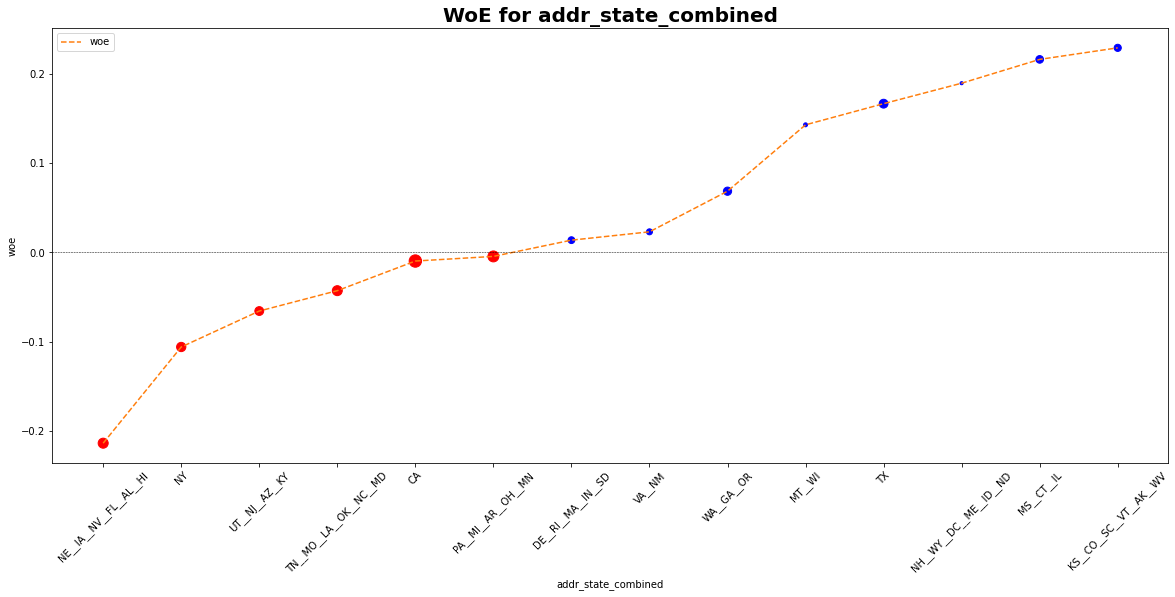

In [248]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df, ax=ax);
plt.xticks(rotation=45);

## verification_status

In [249]:
base_col = 'verification_status'

In [250]:
woe_df = get_weight_of_evidence_stats(df[base_col], df['good_bad_loan'], {0: 'bad', 1: 'good'})
woe_df

,verification_status,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,Verified,33641,0.869653,0.130347,29256.0,4385.0,0.353205,0.420543,-0.174497,NaN,NaN,0.021921
1,Source Verified,29963,0.892567,0.107433,26744.0,3219.0,0.322878,0.308718,0.044848,0.022914,0.219344,0.021921
2,Not Verified,29653,0.904799,0.095201,26830.0,2823.0,0.323916,0.270739,0.179329,0.012231,0.134481,0.021921


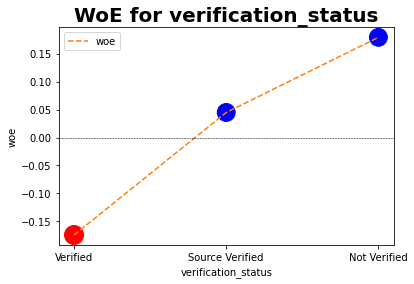

In [251]:
plot_by_woe(woe_df);

* We need not do anything as categories are anyway very less and really different from each other as well
* Seems like verified customers default more than Not Verified? Hmmm

In [252]:
DUMMY_VARIABLES[base_col] = list(woe_df.iloc[:, 0])

## purpose

In [253]:
base_col = 'purpose'

In [254]:
woe_df = get_weight_of_evidence_stats(df[base_col], df['good_bad_loan'], {0: 'bad', 1: 'good'})
woe_df

,purpose,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,educational,89,0.752809,0.247191,67.0,22.0,0.000809,0.002110,-0.958742,NaN,NaN,0.044698
1,renewable_energy,70,0.771429,0.228571,54.0,16.0,0.000652,0.001534,-0.855996,0.018620,0.102745,0.044698
2,small_business,1431,0.774284,0.225716,1108.0,323.0,0.013377,0.030977,-0.839732,0.002855,0.016264,0.044698
3,medical,918,0.855120,0.144880,785.0,133.0,0.009477,0.012755,-0.297057,0.080836,0.542675,0.044698
4,other,4806,0.858302,0.141698,4125.0,681.0,0.049801,0.065311,-0.271133,0.003182,0.025924,0.044698
5,house,439,0.858770,0.141230,377.0,62.0,0.004551,0.005946,-0.267281,0.000468,0.003852,0.044698
6,wedding,456,0.864035,0.135965,394.0,62.0,0.004757,0.005946,-0.223175,0.005265,0.044106,0.044698
7,moving,602,0.873754,0.126246,526.0,76.0,0.006350,0.007289,-0.137824,0.009719,0.085351,0.044698
8,vacation,496,0.875000,0.125000,434.0,62.0,0.005240,0.005946,-0.126482,0.001246,0.011342,0.044698
9,debt_consolidation,55012,0.883098,0.116902,48581.0,6431.0,0.586515,0.616764,-0.050289,0.008098,0.076192,0.044698


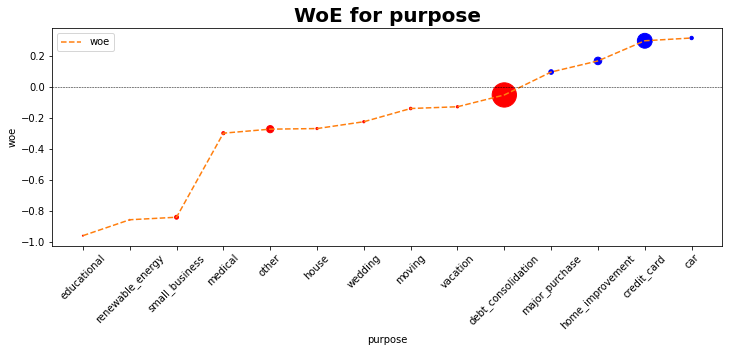

In [255]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_by_woe(woe_df, ax=ax);
plt.xticks(rotation=45);

In [256]:
combined_cat_names = [('small_business', 'educational', 'moving', 'house'),
                      ('other', 'renewable_energy', 'medical', 'vacation', 'wedding'),
                      ('debt_consolidation',),
                      ('home_improvement', 'major_purchase', 'car'),
                      ('credit_card',)]


combined_cat_names

[('small_business', 'educational', 'moving', 'house'),
 ('other', 'renewable_energy', 'medical', 'vacation', 'wedding'),
 ('debt_consolidation',),
 ('home_improvement', 'major_purchase', 'car'),
 ('credit_card',)]

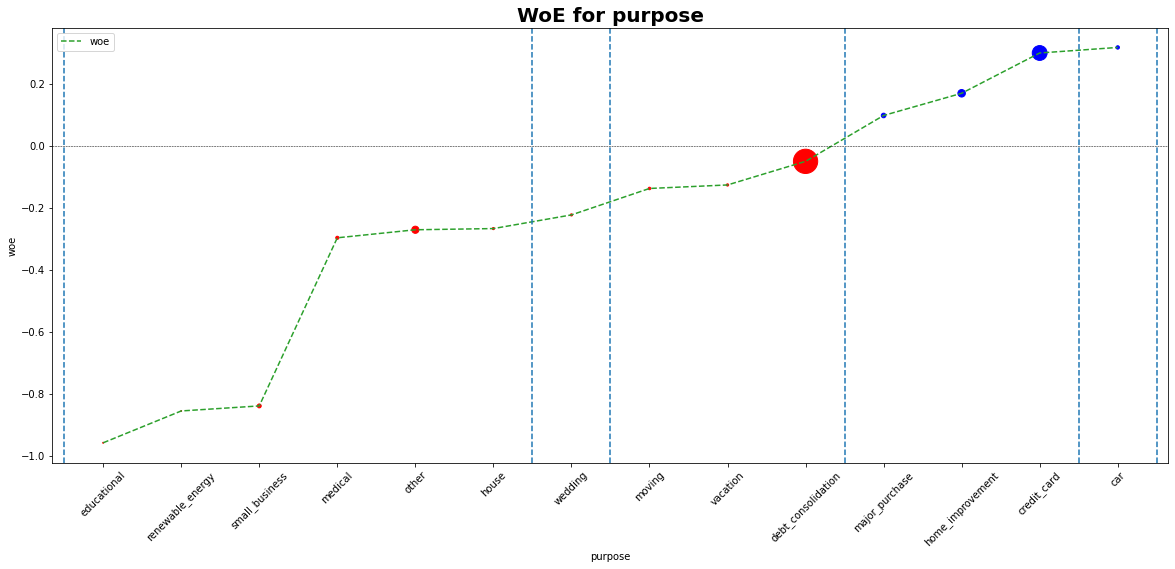

In [257]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(woe_df[base_col].to_numpy(), np.zeros(shape=woe_df.shape[0]), linewidth=0)
plot_by_woe(woe_df, ax=ax);

xticklabels = [label.get_text() for label in ax.get_xticklabels()]
xticks = ax.get_xticks()

tick_width = (xticks[0] + xticks[1])/2

ax.axvline(xticks[0] - tick_width, linestyle='--')
for combine_cols in combined_cat_names:
    idx = xticklabels.index(combine_cols[-1])
    try:
        tick_pos = (xticks[idx] + xticks[idx+1])/2
    except IndexError:
        tick_pos = (xticks[idx] + tick_width)
    
    ax.axvline(tick_pos, linestyle='--')

plt.xticks(rotation=45);

In [258]:
combined_cat_df = []
for cols in combined_cat_names:
    combined_cat = pd.DataFrame(combine_ohe_cat(base_col, cols, df))

    combined_cat_df.append(combined_cat)

combined_cat_df = pd.concat(combined_cat_df, axis=1)
combined_cat_df

,purpose:small_business__educational__moving__house,purpose:other__renewable_energy__medical__vacation__wedding,purpose:debt_consolidation,purpose:home_improvement__major_purchase__car,purpose:credit_card
362514,0,0,0,1,0
288564,0,0,0,0,1
213591,0,0,1,0,0
263083,0,0,1,0,0
165001,0,0,1,0,0
...,...,...,...,...,...
115,0,0,0,0,1
296284,0,0,1,0,0
61777,0,0,1,0,0
91763,0,0,1,0,0


In [259]:
df = pd.concat([df, combined_cat_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,addr_state:NY,addr_state:NC,addr_state:ND,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VT,addr_state:VA,addr_state:WA,addr_state:WV,addr_state:WI,addr_state:WY,addr_state:DC,initial_list_status:f,initial_list_status:w,good_bad_loan,home_ownership_combined,home_ownership:OTHER__NONE__ANY__RENT,addr_state:NE__IA__NV__FL__AL__HI,addr_state:VA__NM,addr_state:TN__MO__LA__OK__NC__MD,addr_state:UT__NJ__AZ__KY,addr_state:PA__MI__AR__OH__MN,addr_state:DE__RI__MA__IN__SD,addr_state:WA__GA__OR,addr_state:MT__WI,addr_state:MS__CT__IL,addr_state:KS__CO__SC__VT__AK__WV,addr_state:NH__WY__DC__ME__ID__ND,addr_state_combined,purpose:small_business__educational__moving__house,purpose:other__renewable_energy__medical__vacation__wedding,purpose:home_improvement__major_purchase__car
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,C5,Licensed vocational nurse,< 1 year,MORTGAGE,65000.0,Verified,2014-07-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,950xx,CA,9.32,0.0,2002-04-01,0.0,NaN,NaN,7.0,0.0,1208,4.3,20.0,f,0.00,0.00,38213.56000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0,0,0,0,0,0,0,0,0,0,0,0,CA,0,0,1
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,E4,shift manager,10+ years,MORTGAGE,60000.0,Verified,2014-10-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,472xx,IN,24.19,1.0,2003-08-01,0.0,3.0,NaN,18.0,0.0,13129,54.7,43.0,w,9214.67,9214.67,4450.12000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,MORTGAGE,0,0,0,0,0,0,1,0,0,0,0,0,DE__RI__MA__IN__SD,0,0,0
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,C2,FastMed urgent care,1 year,MORTGAGE,175000.0,Verified,2012-06-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/06/12 > I am seeking a de...,debt_consolidation,Debt Consolidation,852xx,AZ,13.34,0.0,2002-03-01,0.0,41.0,NaN,9.0,0.0,1906,22.4,38.0,f,0.00,0.00,32388.64000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0,0,0,0,1,0,0,0,0,0,0,0,UT__NJ__AZ__KY,0,0,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,C4,Registered Nurse,2 years,MORTGAGE,66000.0,Source Verified,2014-11-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,498xx,MI,17.69,0.0,2008-08-01,0.0,NaN,NaN,12.0,0.0,12944,74.4,31.0,w,11901.76,11901.76,4719.18000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,MORTGAGE,0,0,0,0,0,1,0,0,0,0,0,0,PA__MI__AR__OH__MN,0,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,A5,Courier Times,10+ years,MORTGAGE,85000.0,Verified,2013-02-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 02/06/13 > I need to cosolid...,debt_consolidation,Consolidate 2013,190xx,PA,8.30,0.0,1986-10-01,0.0,39.0,NaN,7.0,0.0,5902,67.8,20.0,f,0.00,0.00,16628.33315,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0,0,0,0,0,1,0,0,0,0,0,0,PA__MI__AR__OH__MN,0,0,0


In [260]:
cat_map_dict = {}

for combine_cols in combined_cat_names:
    for col in combine_cols:
        cat_map_dict[col] = '__'.join(combine_cols)

cat_map_dict

{'car': 'home_improvement__major_purchase__car',
 'credit_card': 'credit_card',
 'debt_consolidation': 'debt_consolidation',
 'educational': 'small_business__educational__moving__house',
 'home_improvement': 'home_improvement__major_purchase__car',
 'house': 'small_business__educational__moving__house',
 'major_purchase': 'home_improvement__major_purchase__car',
 'medical': 'other__renewable_energy__medical__vacation__wedding',
 'moving': 'small_business__educational__moving__house',
 'other': 'other__renewable_energy__medical__vacation__wedding',
 'renewable_energy': 'other__renewable_energy__medical__vacation__wedding',
 'small_business': 'small_business__educational__moving__house',
 'vacation': 'other__renewable_energy__medical__vacation__wedding',
 'wedding': 'other__renewable_energy__medical__vacation__wedding'}

In [261]:
df[f'{base_col}_combined'] = map_cat(df[base_col], cat_map_dict)
df[f'{base_col}_combined'].unique()

array(['home_improvement__major_purchase__car', 'credit_card',
       'debt_consolidation',
       'other__renewable_energy__medical__vacation__wedding',
       'small_business__educational__moving__house'], dtype=object)

In [262]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_combined'], df['good_bad_loan'], {0: 'bad', 1: 'good'})
woe_df

,purpose_combined,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,small_business__educational__moving__house,2561,0.811402,0.188598,2078.0,483.0,0.025088,0.046322,-0.613247,NaN,NaN,0.04037
1,other__renewable_energy__medical__vacation__we...,6746,0.858583,0.141417,5792.0,954.0,0.069926,0.091493,-0.268822,0.047181,0.344425,0.04037
2,debt_consolidation,55012,0.883098,0.116902,48581.0,6431.0,0.586515,0.616764,-0.050289,0.024515,0.218533,0.04037
3,home_improvement__major_purchase__car,8362,0.903970,0.096030,7559.0,803.0,0.091259,0.077012,0.169748,0.020872,0.220037,0.04037
4,credit_card,20576,0.914658,0.085342,18820.0,1756.0,0.227212,0.168409,0.299490,0.010688,0.129742,0.04037


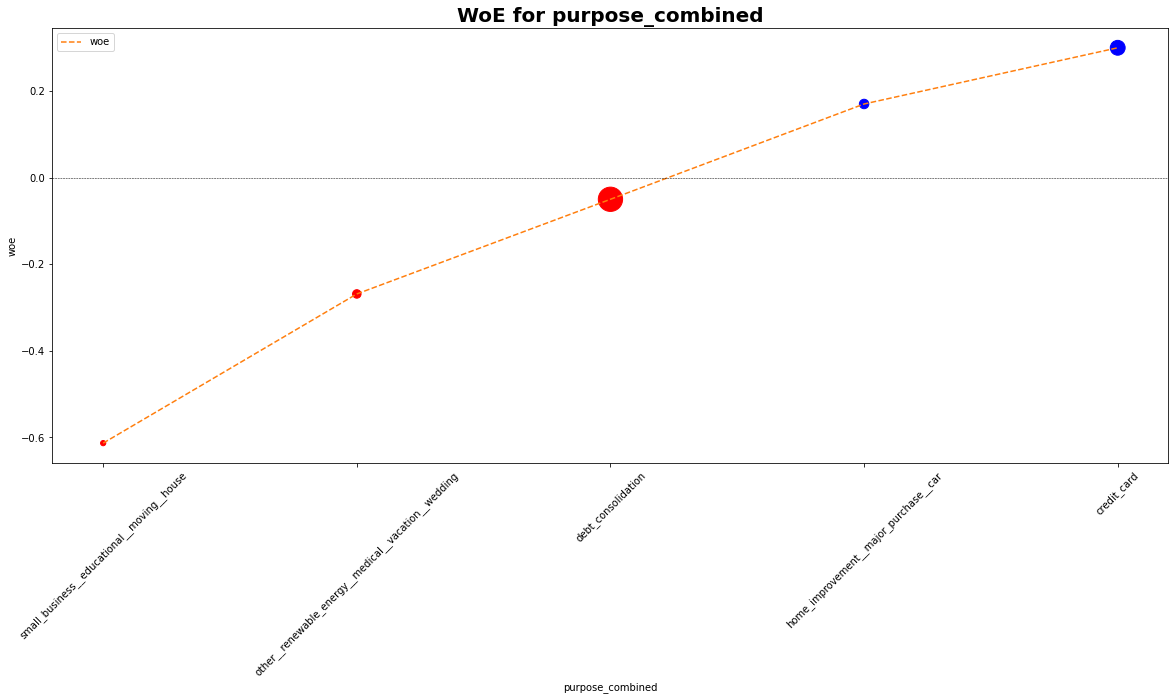

In [263]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df, ax=ax);
plt.xticks(rotation=45);

In [264]:
DUMMY_VARIABLES[base_col] = list(woe_df.iloc[:, 0])

## initial_list_status

In [265]:
base_col = 'initial_list_status'

In [266]:
woe_df = get_weight_of_evidence_stats(df[base_col], df['good_bad_loan'], {0: 'bad', 1: 'good'})
woe_df

,initial_list_status,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,f,60491,0.877602,0.122398,53087.0,7404.0,0.640915,0.71008,-0.102480,NaN,NaN,0.021886
1,w,32766,0.907740,0.092260,29743.0,3023.0,0.359085,0.28992,0.213952,0.030138,0.316432,0.021886


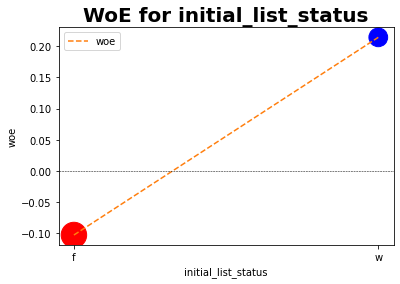

In [267]:
plot_by_woe(woe_df);

In [268]:
DUMMY_VARIABLES[base_col] = list(woe_df.iloc[:, 0])

In [269]:
DUMMY_VARIABLES

{'grade': ['G', 'F', 'E', 'D', 'C', 'B', 'A'],
 'home_ownership': ['OTHER__NONE__ANY__RENT', 'OWN', 'MORTGAGE'],
 'initial_list_status': ['f', 'w'],
 'purpose': ['small_business__educational__moving__house',
  'other__renewable_energy__medical__vacation__wedding',
  'debt_consolidation',
  'home_improvement__major_purchase__car',
  'credit_card'],
 'verification_status': ['Verified', 'Source Verified', 'Not Verified']}

## Preprocessing continous variables

## term_int

In [270]:
base_col = 'term_int'

In [271]:
woe_df = get_weight_of_evidence_stats(df[base_col], df['good_bad_loan'], {0: 'bad', 1: 'good'})
woe_df.sort_values(woe_df.columns[0], inplace=True)
woe_df

,term_int,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
1,36,67534,0.900376,0.099624,60806.0,6728.0,0.734106,0.645248,0.129019,0.044177,0.41734,0.037084
0,60,25723,0.856199,0.143801,22024.0,3699.0,0.265894,0.354752,-0.288321,NaN,NaN,0.037084


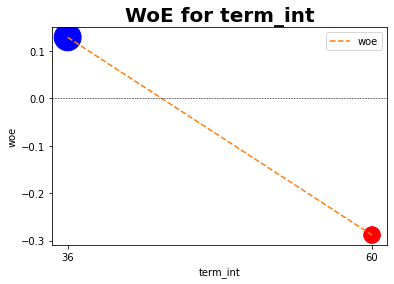

In [272]:
plot_by_woe(woe_df);

Here we just have to make two categories for `term_int`

In [273]:
dummy_cols = pd.get_dummies(df['term_int'], prefix=base_col, prefix_sep=':')
df = pd.concat([df, dummy_cols], axis=1)
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VT,addr_state:VA,addr_state:WA,addr_state:WV,addr_state:WI,addr_state:WY,addr_state:DC,initial_list_status:f,initial_list_status:w,good_bad_loan,home_ownership_combined,home_ownership:OTHER__NONE__ANY__RENT,addr_state:NE__IA__NV__FL__AL__HI,addr_state:VA__NM,addr_state:TN__MO__LA__OK__NC__MD,addr_state:UT__NJ__AZ__KY,addr_state:PA__MI__AR__OH__MN,addr_state:DE__RI__MA__IN__SD,addr_state:WA__GA__OR,addr_state:MT__WI,addr_state:MS__CT__IL,addr_state:KS__CO__SC__VT__AK__WV,addr_state:NH__WY__DC__ME__ID__ND,addr_state_combined,purpose:small_business__educational__moving__house,purpose:other__renewable_energy__medical__vacation__wedding,purpose:home_improvement__major_purchase__car,purpose_combined,term_int:36,term_int:60
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,C5,Licensed vocational nurse,< 1 year,MORTGAGE,65000.0,Verified,2014-07-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,950xx,CA,9.32,0.0,2002-04-01,0.0,NaN,NaN,7.0,0.0,1208,4.3,20.0,f,0.00,0.00,38213.56000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0,0,0,0,0,0,0,0,0,0,0,0,CA,0,0,1,home_improvement__major_purchase__car,0,1
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,E4,shift manager,10+ years,MORTGAGE,60000.0,Verified,2014-10-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,472xx,IN,24.19,1.0,2003-08-01,0.0,3.0,NaN,18.0,0.0,13129,54.7,43.0,w,9214.67,9214.67,4450.12000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,MORTGAGE,0,0,0,0,0,0,1,0,0,0,0,0,DE__RI__MA__IN__SD,0,0,0,credit_card,0,1
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,C2,FastMed urgent care,1 year,MORTGAGE,175000.0,Verified,2012-06-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/06/12 > I am seeking a de...,debt_consolidation,Debt Consolidation,852xx,AZ,13.34,0.0,2002-03-01,0.0,41.0,NaN,9.0,0.0,1906,22.4,38.0,f,0.00,0.00,32388.64000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0,0,0,0,1,0,0,0,0,0,0,0,UT__NJ__AZ__KY,0,0,0,debt_consolidation,1,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,C4,Registered Nurse,2 years,MORTGAGE,66000.0,Source Verified,2014-11-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,498xx,MI,17.69,0.0,2008-08-01,0.0,NaN,NaN,12.0,0.0,12944,74.4,31.0,w,11901.76,11901.76,4719.18000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,MORTGAGE,0,0,0,0,0,1,0,0,0,0,0,0,PA__MI__AR__OH__MN,0,0,0,debt_consolidation,0,1
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,A5,Courier Times,10+ years,MORTGAGE,85000.0,Verified,2013-02-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 02/06/13 > I need to cosolid...,debt_consolidation,Consolidate 2013,190xx,PA,8.30,0.0,1986-10-01,0.0,39.0,NaN,7.0,0.0,5902,67.8,20.0,f,0.00,0.00,16628.33315,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0,0,0,0,0,1,0,0,0,0,0,0,PA__MI__AR__OH__MN,0,0,0,debt_consolidation,1,0


In [274]:
DUMMY_VARIABLES[base_col] = list(woe_df.iloc[:, 0])
DUMMY_VARIABLES

{'grade': ['G', 'F', 'E', 'D', 'C', 'B', 'A'],
 'home_ownership': ['OTHER__NONE__ANY__RENT', 'OWN', 'MORTGAGE'],
 'initial_list_status': ['f', 'w'],
 'purpose': ['small_business__educational__moving__house',
  'other__renewable_energy__medical__vacation__wedding',
  'debt_consolidation',
  'home_improvement__major_purchase__car',
  'credit_card'],
 'term_int': [36, 60],
 'verification_status': ['Verified', 'Source Verified', 'Not Verified']}

## emp_length_int

In [275]:
base_col = 'emp_length_int'

In [276]:
def sorter_feat_func(d):
    return d.iloc[:, 0]

In [277]:
woe_df = get_weight_of_evidence_stats(df[base_col], df['good_bad_loan'], {0: 'bad', 1: 'good'}, sorter_feat_func)
woe_df

,emp_length_int,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,0,11553,0.871289,0.128711,10066.0,1487.0,0.121526,0.142611,-0.159989,NaN,NaN,0.007786
1,1,5968,0.890751,0.109249,5316.0,652.0,0.064180,0.062530,0.026040,0.019462,0.186029,0.007786
2,2,8295,0.885594,0.114406,7346.0,949.0,0.088688,0.091014,-0.025889,0.005157,0.051929,0.007786
3,3,7391,0.886484,0.113516,6552.0,839.0,0.079102,0.080464,-0.017077,0.000890,0.008812,0.007786
4,4,5555,0.887129,0.112871,4928.0,627.0,0.059495,0.060132,-0.010650,0.000645,0.006427,0.007786
5,5,6172,0.883668,0.116332,5454.0,718.0,0.065846,0.068860,-0.044757,0.003461,0.034107,0.007786
6,6,5225,0.876555,0.123445,4580.0,645.0,0.055294,0.061859,-0.112188,0.007113,0.067431,0.007786
7,7,5131,0.890080,0.109920,4567.0,564.0,0.055137,0.054090,0.019166,0.013525,0.131354,0.007786
8,8,4542,0.886834,0.113166,4028.0,514.0,0.048630,0.049295,-0.013590,0.003246,0.032756,0.007786
9,9,3621,0.890362,0.109638,3224.0,397.0,0.038923,0.038074,0.022050,0.003528,0.035640,0.007786


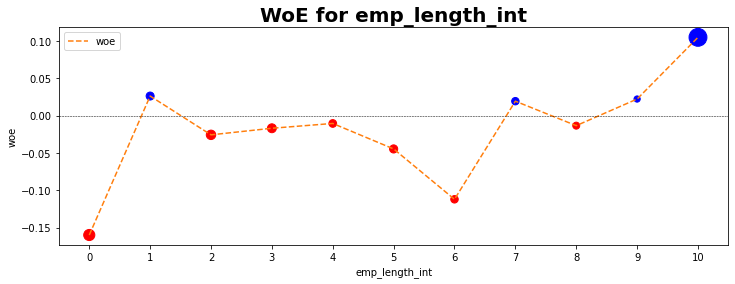

In [278]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_by_woe(woe_df, ax=ax);


In [279]:
combined_cat_range = [(0,),
                      (1,),
                      (2, 4),
                      (5, 6),
                      (7, 9),
                      (10,)]

cat_names = ['0', '1', '2-4', '5-6', '7-9', '10']

In [280]:
def get_category(x, combined_cat_range):
    ccr = combined_cat_range

    for cr in ccr:
        if x in range(cr[0], cr[-1] +1):
            if cr[0] == cr[-1]:
                return str(cr[0])
            else:
                return f'{cr[0]}-{cr[-1]}'


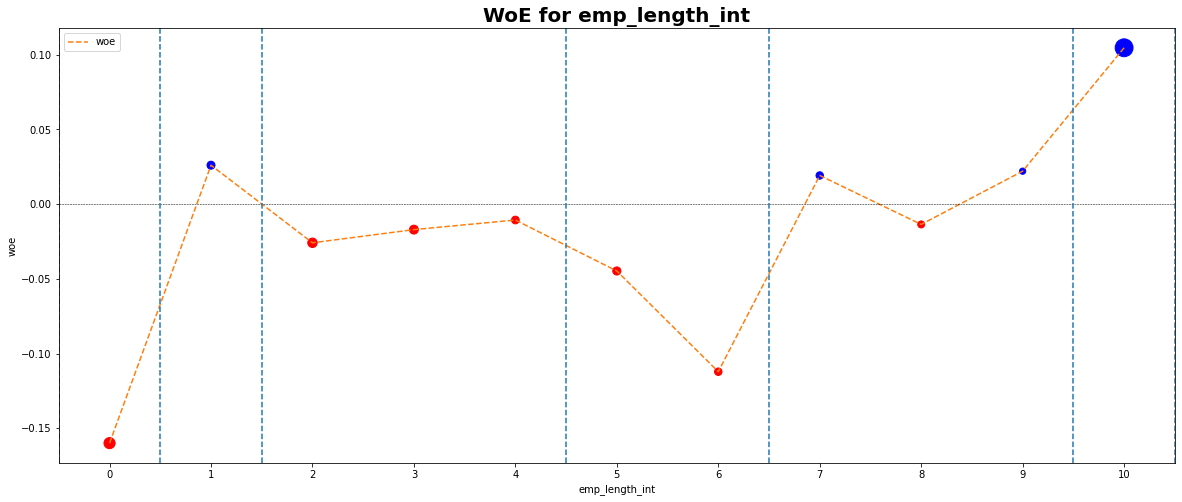

In [281]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df, ax=ax);

xticks = ax.get_xticks()

ax.axvline(xticks[0] - 0.5, linestyle='--')

for i, cat_range in enumerate(combined_cat_range):
        try:
            tick_pos = (combined_cat_range[i][-1] + combined_cat_range[i+1][0])/2
            
        except IndexError:
            tick_pos = combined_cat_range[i][0] + 0.5

        ax.axvline(tick_pos, linestyle='--')



In [282]:
df[f'{base_col}_combined'] = df[base_col].apply(get_category, combined_cat_range=combined_cat_range)
df[f'{base_col}_combined'] = pd.Categorical(df[f'{base_col}_combined'], categories=cat_names, ordered=True)

In [283]:
combined_cat_df = pd.get_dummies(df[f'{base_col}_combined'], prefix=base_col, prefix_sep=':')
ordered_cols = sorted(combined_cat_df.columns, key=lambda x: int(x.split(':')[-1].split('-')[0]))
combined_cat_df = combined_cat_df[ordered_cols]
combined_cat_df

,emp_length_int:0,emp_length_int:1,emp_length_int:2-4,emp_length_int:5-6,emp_length_int:7-9,emp_length_int:10
362514,1,0,0,0,0,0
288564,0,0,0,0,0,1
213591,0,1,0,0,0,0
263083,0,0,1,0,0,0
165001,0,0,0,0,0,1
...,...,...,...,...,...,...
115,0,0,0,0,1,0
296284,0,0,1,0,0,0
61777,0,0,1,0,0,0
91763,0,0,0,0,1,0


In [284]:
df = pd.concat([df, combined_cat_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VT,addr_state:VA,addr_state:WA,addr_state:WV,addr_state:WI,addr_state:WY,addr_state:DC,initial_list_status:f,initial_list_status:w,good_bad_loan,home_ownership_combined,home_ownership:OTHER__NONE__ANY__RENT,addr_state:NE__IA__NV__FL__AL__HI,addr_state:VA__NM,addr_state:TN__MO__LA__OK__NC__MD,addr_state:UT__NJ__AZ__KY,addr_state:PA__MI__AR__OH__MN,addr_state:DE__RI__MA__IN__SD,addr_state:WA__GA__OR,addr_state:MT__WI,addr_state:MS__CT__IL,addr_state:KS__CO__SC__VT__AK__WV,addr_state:NH__WY__DC__ME__ID__ND,addr_state_combined,purpose:small_business__educational__moving__house,purpose:other__renewable_energy__medical__vacation__wedding,purpose:home_improvement__major_purchase__car,purpose_combined,term_int:36,term_int:60,emp_length_int_combined,emp_length_int:0,emp_length_int:1,emp_length_int:2-4,emp_length_int:5-6,emp_length_int:7-9,emp_length_int:10
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,C5,Licensed vocational nurse,< 1 year,MORTGAGE,65000.0,Verified,2014-07-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,950xx,CA,9.32,0.0,2002-04-01,0.0,NaN,NaN,7.0,0.0,1208,4.3,20.0,f,0.00,0.00,38213.56000,...,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0,0,0,0,0,0,0,0,0,0,0,0,CA,0,0,1,home_improvement__major_purchase__car,0,1,0,1,0,0,0,0,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,E4,shift manager,10+ years,MORTGAGE,60000.0,Verified,2014-10-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,472xx,IN,24.19,1.0,2003-08-01,0.0,3.0,NaN,18.0,0.0,13129,54.7,43.0,w,9214.67,9214.67,4450.12000,...,0,0,0,0,0,0,0,0,0,0,0,1,1,MORTGAGE,0,0,0,0,0,0,1,0,0,0,0,0,DE__RI__MA__IN__SD,0,0,0,credit_card,0,1,10,0,0,0,0,0,1
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,C2,FastMed urgent care,1 year,MORTGAGE,175000.0,Verified,2012-06-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/06/12 > I am seeking a de...,debt_consolidation,Debt Consolidation,852xx,AZ,13.34,0.0,2002-03-01,0.0,41.0,NaN,9.0,0.0,1906,22.4,38.0,f,0.00,0.00,32388.64000,...,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0,0,0,0,1,0,0,0,0,0,0,0,UT__NJ__AZ__KY,0,0,0,debt_consolidation,1,0,1,0,1,0,0,0,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,C4,Registered Nurse,2 years,MORTGAGE,66000.0,Source Verified,2014-11-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,498xx,MI,17.69,0.0,2008-08-01,0.0,NaN,NaN,12.0,0.0,12944,74.4,31.0,w,11901.76,11901.76,4719.18000,...,0,0,0,0,0,0,0,0,0,0,0,1,1,MORTGAGE,0,0,0,0,0,1,0,0,0,0,0,0,PA__MI__AR__OH__MN,0,0,0,debt_consolidation,0,1,2-4,0,0,1,0,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,A5,Courier Times,10+ years,MORTGAGE,85000.0,Verified,2013-02-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 02/06/13 > I need to cosolid...,debt_consolidation,Consolidate 2013,190xx,PA,8.30,0.0,1986-10-01,0.0,39.0,NaN,7.0,0.0,5902,67.8,20.0,f,0.00,0.00,16628.33315,...,0,0,0,0,0,0,0,0,0,0,1,0,1,MORTGAGE,0,0,0,0,0,1,0,0,0,0,0,0,PA__MI__AR__OH__MN,0,0,0,debt_consolidation,1,0,10,0,0,0,0,0,1


In [285]:
def sorter_feat_func(d):
    return d.iloc[:, 0].apply(lambda x: int(x.split('-')[0]))

In [286]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_combined'], df['good_bad_loan'], {0: 'bad', 1: 'good'}, sorter_feat_func)
woe_df

,emp_length_int_combined,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,0,11553,0.871289,0.128711,10066.0,1487.0,0.121526,0.142611,-0.159989,NaN,NaN,0.007597
1,1,5968,0.890751,0.109249,5316.0,652.0,0.064180,0.062530,0.026040,0.019462,0.186029,0.007597
2,2-4,21241,0.886305,0.113695,18826.0,2415.0,0.227285,0.231610,-0.018852,0.004446,0.044892,0.007597
3,5-6,11397,0.880407,0.119593,10034.0,1363.0,0.121140,0.130718,-0.076101,0.005898,0.057248,0.007597
4,7-9,13294,0.889048,0.110952,11819.0,1475.0,0.142690,0.141460,0.008659,0.008641,0.084759,0.007597
5,10,29804,0.898168,0.101832,26769.0,3035.0,0.323180,0.291071,0.104641,0.009120,0.095983,0.007597


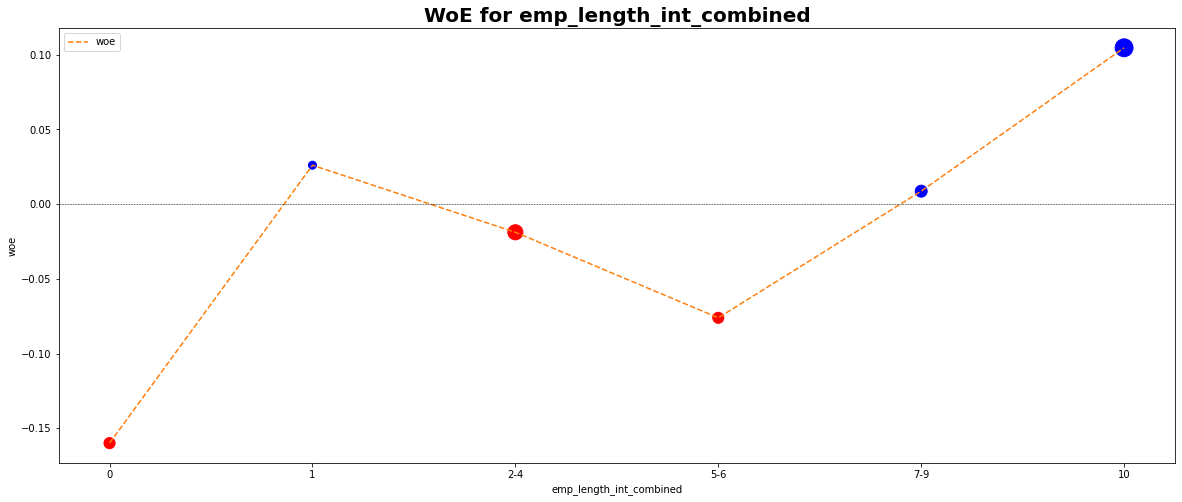

In [287]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df, ax=ax);

In [288]:
DUMMY_VARIABLES[base_col] = list(woe_df.iloc[:, 0])

In [289]:
DUMMY_VARIABLES

{'emp_length_int': ['0', '1', '2-4', '5-6', '7-9', '10'],
 'grade': ['G', 'F', 'E', 'D', 'C', 'B', 'A'],
 'home_ownership': ['OTHER__NONE__ANY__RENT', 'OWN', 'MORTGAGE'],
 'initial_list_status': ['f', 'w'],
 'purpose': ['small_business__educational__moving__house',
  'other__renewable_energy__medical__vacation__wedding',
  'debt_consolidation',
  'home_improvement__major_purchase__car',
  'credit_card'],
 'term_int': [36, 60],
 'verification_status': ['Verified', 'Source Verified', 'Not Verified']}

## mths_since_issue_d

In [290]:
base_col = 'mths_since_issue_d'

In [291]:
def sorter_feat_func(d):
    return d.iloc[:, 0]

In [292]:
df[f'{base_col}_binned'] = pd.cut(df[base_col], 50)

In [293]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_binned'], df['good_bad_loan'], {0: 'bad', 1: 'good'}, sorter_feat_func)
woe_df

,mths_since_issue_d_binned,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,"(35.91, 37.8]",7191,0.941872,0.058128,6773.0,418.0,0.081770,0.040088,0.712826,NaN,NaN,0.113435
1,"(37.8, 39.6]",9752,0.926169,0.073831,9032.0,720.0,0.109043,0.069052,0.456886,0.015703,0.255940,0.113435
2,"(39.6, 41.4]",9506,0.916053,0.083947,8708.0,798.0,0.105131,0.076532,0.317497,0.010116,0.139389,0.113435
3,"(41.4, 43.2]",7240,0.906768,0.093232,6565.0,675.0,0.079259,0.064736,0.202403,0.009285,0.115094,0.113435
4,"(43.2, 45.0]",7217,0.900097,0.099903,6496.0,721.0,0.078426,0.069147,0.125911,0.006671,0.076492,0.113435
5,"(45.0, 46.8]",3104,0.893686,0.106314,2774.0,330.0,0.033490,0.031649,0.056561,0.006411,0.069350,0.113435
6,"(46.8, 48.6]",6197,0.886881,0.113119,5496.0,701.0,0.066353,0.067229,-0.013124,0.006805,0.069685,0.113435
7,"(48.6, 50.4]",5821,0.883697,0.116303,5144.0,677.0,0.062103,0.064928,-0.044477,0.003184,0.031353,0.113435
8,"(50.4, 52.2]",5021,0.876917,0.123083,4403.0,618.0,0.053157,0.059269,-0.108839,0.006780,0.064362,0.113435
9,"(52.2, 54.0]",4497,0.870136,0.129864,3913.0,584.0,0.047241,0.056008,-0.170233,0.006781,0.061394,0.113435


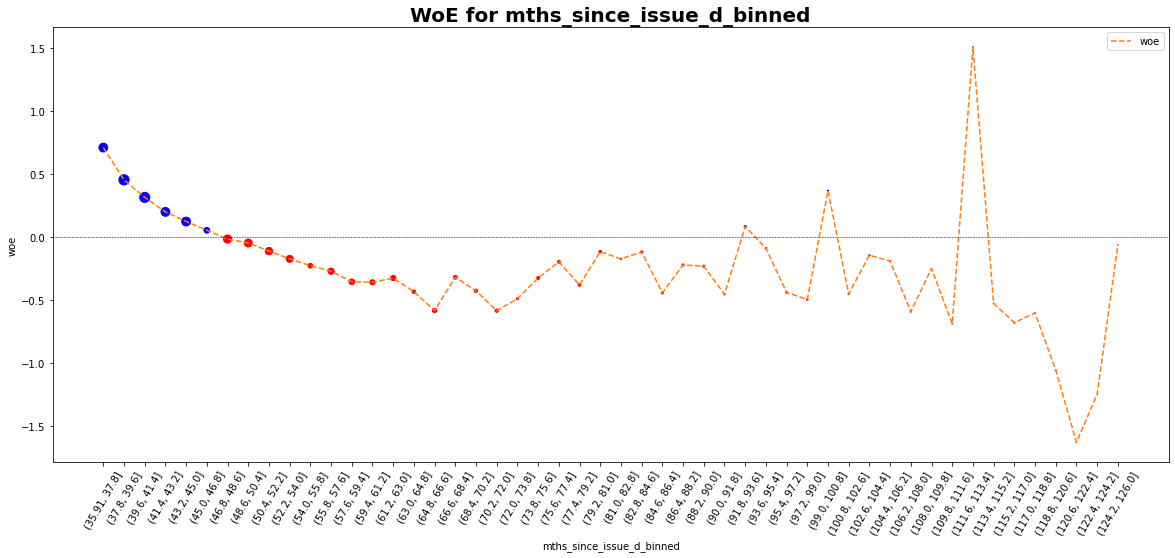

In [294]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.astype({woe_df.columns[0]: str}), ax=ax);
plt.xticks(rotation=60);

In [295]:
combined_cat_range = [(38,),
                      (38, 40),
                      (40, 42),
                      (42, 49),
                      (49, 53),
                      (53, 65),
                      (65, 85),
                      (85,)]


In [296]:
def get_category_name(cat_range, idx):
    cr = cat_range

    if (cr[0] == cr[-1]):
        if idx == 0:
            return f'<={cr[0]}'
        else:
            return f'>={cr[0]}'
    else:
        return f'{cr[0]}-{cr[-1]}'


In [297]:
cat_names = [get_category_name(cr, i) for i, cr in enumerate(combined_cat_range)]
cat_names

['<=38', '38-40', '40-42', '42-49', '49-53', '53-65', '65-85', '>=85']

In [298]:
def get_category(x, combined_cat_range):
    ccr = combined_cat_range
    n = len(ccr)
    for i, cr in enumerate(ccr):
        if i == 0:
            comp_res = x <= cr[0]
        elif i == (n - 1):
            comp_res = x > cr[0]
        else:
            comp_res = x in range(cr[0], cr[-1] + 1)
        
        if comp_res:
            return get_category_name(cr, i)
        

In [299]:
df[f'{base_col}_combined'] = df[base_col].apply(get_category, combined_cat_range=combined_cat_range)
df[f'{base_col}_combined'] = pd.Categorical(df[f'{base_col}_combined'], categories=cat_names, ordered=True)


In [300]:
df[f'{base_col}_combined'].unique()

['40-42', '<=38', '65-85', '53-65', '49-53', '>=85', '42-49', '38-40']
Categories (8, object): ['<=38' < '38-40' < '40-42' < '42-49' < '49-53' < '53-65' < '65-85' < '>=85']

In [301]:
combined_cat_df = pd.get_dummies(df[f'{base_col}_combined'], prefix=base_col, prefix_sep=':')
combined_cat_df

,mths_since_issue_d:<=38,mths_since_issue_d:38-40,mths_since_issue_d:40-42,mths_since_issue_d:42-49,mths_since_issue_d:49-53,mths_since_issue_d:53-65,mths_since_issue_d:65-85,mths_since_issue_d:>=85
362514,0,0,1,0,0,0,0,0
288564,1,0,0,0,0,0,0,0
213591,0,0,0,0,0,0,1,0
263083,1,0,0,0,0,0,0,0
165001,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
115,0,0,0,0,0,0,1,0
296284,1,0,0,0,0,0,0,0
61777,0,0,0,1,0,0,0,0
91763,0,0,0,0,1,0,0,0


In [302]:
df = pd.concat([df, combined_cat_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,initial_list_status:f,initial_list_status:w,good_bad_loan,home_ownership_combined,home_ownership:OTHER__NONE__ANY__RENT,addr_state:NE__IA__NV__FL__AL__HI,addr_state:VA__NM,addr_state:TN__MO__LA__OK__NC__MD,addr_state:UT__NJ__AZ__KY,addr_state:PA__MI__AR__OH__MN,addr_state:DE__RI__MA__IN__SD,addr_state:WA__GA__OR,addr_state:MT__WI,addr_state:MS__CT__IL,addr_state:KS__CO__SC__VT__AK__WV,addr_state:NH__WY__DC__ME__ID__ND,addr_state_combined,purpose:small_business__educational__moving__house,purpose:other__renewable_energy__medical__vacation__wedding,purpose:home_improvement__major_purchase__car,purpose_combined,term_int:36,term_int:60,emp_length_int_combined,emp_length_int:0,emp_length_int:1,emp_length_int:2-4,emp_length_int:5-6,emp_length_int:7-9,emp_length_int:10,mths_since_issue_d_binned,mths_since_issue_d_combined,mths_since_issue_d:<=38,mths_since_issue_d:38-40,mths_since_issue_d:40-42,mths_since_issue_d:42-49,mths_since_issue_d:49-53,mths_since_issue_d:53-65,mths_since_issue_d:65-85,mths_since_issue_d:>=85
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,C5,Licensed vocational nurse,< 1 year,MORTGAGE,65000.0,Verified,2014-07-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,950xx,CA,9.32,0.0,2002-04-01,0.0,NaN,NaN,7.0,0.0,1208,4.3,20.0,f,0.00,0.00,38213.56000,...,1,0,1,MORTGAGE,0,0,0,0,0,0,0,0,0,0,0,0,CA,0,0,1,home_improvement__major_purchase__car,0,1,0,1,0,0,0,0,0,"(39.6, 41.4]",40-42,0,0,1,0,0,0,0,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,E4,shift manager,10+ years,MORTGAGE,60000.0,Verified,2014-10-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,472xx,IN,24.19,1.0,2003-08-01,0.0,3.0,NaN,18.0,0.0,13129,54.7,43.0,w,9214.67,9214.67,4450.12000,...,0,1,1,MORTGAGE,0,0,0,0,0,0,1,0,0,0,0,0,DE__RI__MA__IN__SD,0,0,0,credit_card,0,1,10,0,0,0,0,0,1,"(37.8, 39.6]",<=38,1,0,0,0,0,0,0,0
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,C2,FastMed urgent care,1 year,MORTGAGE,175000.0,Verified,2012-06-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/06/12 > I am seeking a de...,debt_consolidation,Debt Consolidation,852xx,AZ,13.34,0.0,2002-03-01,0.0,41.0,NaN,9.0,0.0,1906,22.4,38.0,f,0.00,0.00,32388.64000,...,1,0,1,MORTGAGE,0,0,0,0,1,0,0,0,0,0,0,0,UT__NJ__AZ__KY,0,0,0,debt_consolidation,1,0,1,0,1,0,0,0,0,"(64.8, 66.6]",65-85,0,0,0,0,0,0,1,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,C4,Registered Nurse,2 years,MORTGAGE,66000.0,Source Verified,2014-11-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,498xx,MI,17.69,0.0,2008-08-01,0.0,NaN,NaN,12.0,0.0,12944,74.4,31.0,w,11901.76,11901.76,4719.18000,...,0,1,1,MORTGAGE,0,0,0,0,0,1,0,0,0,0,0,0,PA__MI__AR__OH__MN,0,0,0,debt_consolidation,0,1,2-4,0,0,1,0,0,0,"(35.91, 37.8]",<=38,1,0,0,0,0,0,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,A5,Courier Times,10+ years,MORTGAGE,85000.0,Verified,2013-02-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 02/06/13 > I need to cosolid...,debt_consolidation,Consolidate 2013,190xx,PA,8.30,0.0,1986-10-01,0.0,39.0,NaN,7.0,0.0,5902,67.8,20.0,f,0.00,0.00,16628.33315,...,1,0,1,MORTGAGE,0,0,0,0,0,1,0,0,0,0,0,0,PA__MI__AR__OH__MN,0,0,0,debt_consolidation,1,0,10,0,0,0,0,0,1,"(57.6, 59.4]",53-65,0,0,0,0,0,1,0,0


In [303]:
DUMMY_VARIABLES[base_col] = list(combined_cat_df.columns.str.replace(f'{base_col}:', ''))
DUMMY_VARIABLES

{'emp_length_int': ['0', '1', '2-4', '5-6', '7-9', '10'],
 'grade': ['G', 'F', 'E', 'D', 'C', 'B', 'A'],
 'home_ownership': ['OTHER__NONE__ANY__RENT', 'OWN', 'MORTGAGE'],
 'initial_list_status': ['f', 'w'],
 'mths_since_issue_d': ['<=38',
  '38-40',
  '40-42',
  '42-49',
  '49-53',
  '53-65',
  '65-85',
  '>=85'],
 'purpose': ['small_business__educational__moving__house',
  'other__renewable_energy__medical__vacation__wedding',
  'debt_consolidation',
  'home_improvement__major_purchase__car',
  'credit_card'],
 'term_int': [36, 60],
 'verification_status': ['Verified', 'Source Verified', 'Not Verified']}

## int_rate

In [304]:
base_col = 'int_rate'

In [305]:
def sorter_feat_func(d):
    return d.iloc[:, 0]

In [306]:
df[f'{base_col}_binned'] = pd.cut(df[base_col], 50)

In [307]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_binned'], df['good_bad_loan'], {0: 'bad', 1: 'good'}, sorter_feat_func)
woe_df

,int_rate_binned,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,"(5.399, 5.833]",198,0.969697,0.030303,192.0,6.0,0.002318,0.000575,1.393344,NaN,NaN,0.370988
1,"(5.833, 6.246]",2086,0.979386,0.020614,2043.0,43.0,0.024665,0.004124,1.788583,0.009689,0.395239,0.370988
2,"(6.246, 6.658]",1974,0.970618,0.029382,1916.0,58.0,0.023132,0.005562,1.425160,0.008768,0.363423,0.370988
3,"(6.658, 7.071]",477,0.947589,0.052411,452.0,25.0,0.005457,0.002398,0.822415,0.023029,0.602746,0.370988
4,"(7.071, 7.484]",804,0.981343,0.018657,789.0,15.0,0.009526,0.001439,1.890324,0.033754,1.067910,0.370988
5,"(7.484, 7.897]",3245,0.964561,0.035439,3130.0,115.0,0.037788,0.011029,1.231464,0.016782,0.658860,0.370988
6,"(7.897, 8.31]",2429,0.949774,0.050226,2307.0,122.0,0.027852,0.011700,0.867290,0.014787,0.364174,0.370988
7,"(8.31, 8.722]",1680,0.963690,0.036310,1619.0,61.0,0.019546,0.005850,1.206298,0.013917,0.339008,0.370988
8,"(8.722, 9.135]",2384,0.940856,0.059144,2243.0,141.0,0.027080,0.013523,0.694418,0.022835,0.511880,0.370988
9,"(9.135, 9.548]",1590,0.976101,0.023899,1552.0,38.0,0.018737,0.003644,1.637322,0.035245,0.942904,0.370988


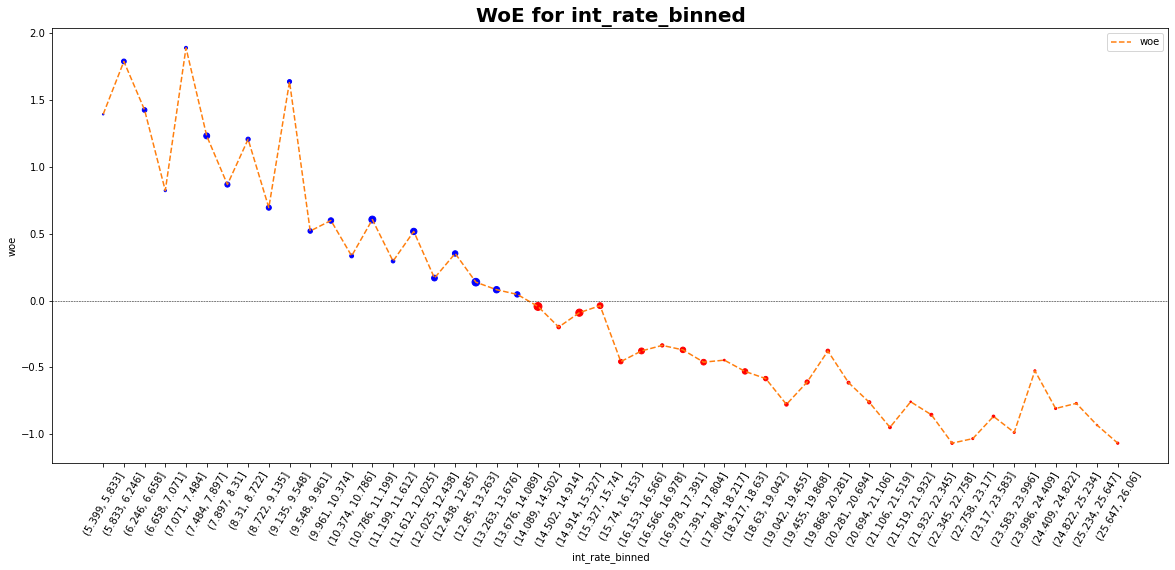

In [308]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.astype({woe_df.columns[0]: str}), ax=ax);
plt.xticks(rotation=60);

In [309]:
combined_cat_range = [(9.548,),
                      (9.548, 12.025),
                      (12.025, 15.327),
                      (15.327, 19.868),
                      (19.868, )]


In [310]:
def get_category_name(cat_range, idx):
    cr = cat_range

    if (cr[0] == cr[-1]):
        if idx == 0:
            return f'<={cr[0]}'
        else:
            return f'>={cr[0]}'
    else:
        return f'{cr[0]}-{cr[-1]}'


In [311]:
cat_names = [get_category_name(cr, i) for i, cr in enumerate(combined_cat_range)]
cat_names

['<=9.548', '9.548-12.025', '12.025-15.327', '15.327-19.868', '>=19.868']

In [312]:
def get_category(x, combined_cat_range):
    ccr = combined_cat_range
    n = len(ccr)
    for i, cr in enumerate(ccr):
        if i == 0:
            comp_res = x <= cr[0]
        elif i == (n - 1):
            comp_res = x > cr[0]
        else:
            comp_res = (x >= cr[0]) and (x < cr[-1])
        
        if comp_res:
            return get_category_name(cr, i)
        

In [313]:
df[f'{base_col}_combined'] = df[base_col].apply(get_category, combined_cat_range=combined_cat_range)
df[f'{base_col}_combined'] = pd.Categorical(df[f'{base_col}_combined'], categories=cat_names, ordered=True)


In [314]:
df[f'{base_col}_combined'].unique()

['12.025-15.327', '>=19.868', '<=9.548', '15.327-19.868', '9.548-12.025']
Categories (5, object): ['<=9.548' < '9.548-12.025' < '12.025-15.327' < '15.327-19.868' <
                         '>=19.868']

In [315]:
combined_cat_df = pd.get_dummies(df[f'{base_col}_combined'], prefix=base_col, prefix_sep=':')
combined_cat_df

,int_rate:<=9.548,int_rate:9.548-12.025,int_rate:12.025-15.327,int_rate:15.327-19.868,int_rate:>=19.868
362514,0,0,1,0,0
288564,0,0,0,0,1
213591,0,0,1,0,0
263083,0,0,1,0,0
165001,1,0,0,0,0
...,...,...,...,...,...
115,0,1,0,0,0
296284,0,1,0,0,0
61777,1,0,0,0,0
91763,1,0,0,0,0


In [316]:
df = pd.concat([df, combined_cat_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,addr_state:TN__MO__LA__OK__NC__MD,addr_state:UT__NJ__AZ__KY,addr_state:PA__MI__AR__OH__MN,addr_state:DE__RI__MA__IN__SD,addr_state:WA__GA__OR,addr_state:MT__WI,addr_state:MS__CT__IL,addr_state:KS__CO__SC__VT__AK__WV,addr_state:NH__WY__DC__ME__ID__ND,addr_state_combined,purpose:small_business__educational__moving__house,purpose:other__renewable_energy__medical__vacation__wedding,purpose:home_improvement__major_purchase__car,purpose_combined,term_int:36,term_int:60,emp_length_int_combined,emp_length_int:0,emp_length_int:1,emp_length_int:2-4,emp_length_int:5-6,emp_length_int:7-9,emp_length_int:10,mths_since_issue_d_binned,mths_since_issue_d_combined,mths_since_issue_d:<=38,mths_since_issue_d:38-40,mths_since_issue_d:40-42,mths_since_issue_d:42-49,mths_since_issue_d:49-53,mths_since_issue_d:53-65,mths_since_issue_d:65-85,mths_since_issue_d:>=85,int_rate_binned,int_rate_combined,int_rate:<=9.548,int_rate:9.548-12.025,int_rate:12.025-15.327,int_rate:15.327-19.868,int_rate:>=19.868
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,C5,Licensed vocational nurse,< 1 year,MORTGAGE,65000.0,Verified,2014-07-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,950xx,CA,9.32,0.0,2002-04-01,0.0,NaN,NaN,7.0,0.0,1208,4.3,20.0,f,0.00,0.00,38213.56000,...,0,0,0,0,0,0,0,0,0,CA,0,0,1,home_improvement__major_purchase__car,0,1,0,1,0,0,0,0,0,"(39.6, 41.4]",40-42,0,0,1,0,0,0,0,0,"(14.914, 15.327]",12.025-15.327,0,0,1,0,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,E4,shift manager,10+ years,MORTGAGE,60000.0,Verified,2014-10-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,472xx,IN,24.19,1.0,2003-08-01,0.0,3.0,NaN,18.0,0.0,13129,54.7,43.0,w,9214.67,9214.67,4450.12000,...,0,0,0,1,0,0,0,0,0,DE__RI__MA__IN__SD,0,0,0,credit_card,0,1,10,0,0,0,0,0,1,"(37.8, 39.6]",<=38,1,0,0,0,0,0,0,0,"(20.694, 21.106]",>=19.868,0,0,0,0,1
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,C2,FastMed urgent care,1 year,MORTGAGE,175000.0,Verified,2012-06-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/06/12 > I am seeking a de...,debt_consolidation,Debt Consolidation,852xx,AZ,13.34,0.0,2002-03-01,0.0,41.0,NaN,9.0,0.0,1906,22.4,38.0,f,0.00,0.00,32388.64000,...,0,1,0,0,0,0,0,0,0,UT__NJ__AZ__KY,0,0,0,debt_consolidation,1,0,1,0,1,0,0,0,0,"(64.8, 66.6]",65-85,0,0,0,0,0,0,1,0,"(14.502, 14.914]",12.025-15.327,0,0,1,0,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,C4,Registered Nurse,2 years,MORTGAGE,66000.0,Source Verified,2014-11-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,498xx,MI,17.69,0.0,2008-08-01,0.0,NaN,NaN,12.0,0.0,12944,74.4,31.0,w,11901.76,11901.76,4719.18000,...,0,0,1,0,0,0,0,0,0,PA__MI__AR__OH__MN,0,0,0,debt_consolidation,0,1,2-4,0,0,1,0,0,0,"(35.91, 37.8]",<=38,1,0,0,0,0,0,0,0,"(14.089, 14.502]",12.025-15.327,0,0,1,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,A5,Courier Times,10+ years,MORTGAGE,85000.0,Verified,2013-02-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 02/06/13 > I need to cosolid...,debt_consolidation,Consolidate 2013,190xx,PA,8.30,0.0,1986-10-01,0.0,39.0,NaN,7.0,0.0,5902,67.8,20.0,f,0.00,0.00,16628.33315,...,0,0,1,0,0,0,0,0,0,PA__MI__AR__OH__MN,0,0,0,debt_consolidation,1,0,10,0,0,0,0,0,1,"(57.6, 59.4]",53-65,0,0,0,0,0,1,0,0,"(8.722, 9.13

In [317]:
DUMMY_VARIABLES[base_col] = list(combined_cat_df.columns.str.replace(f'{base_col}:', ''))
DUMMY_VARIABLES

{'emp_length_int': ['0', '1', '2-4', '5-6', '7-9', '10'],
 'grade': ['G', 'F', 'E', 'D', 'C', 'B', 'A'],
 'home_ownership': ['OTHER__NONE__ANY__RENT', 'OWN', 'MORTGAGE'],
 'initial_list_status': ['f', 'w'],
 'int_rate': ['<=9.548',
  '9.548-12.025',
  '12.025-15.327',
  '15.327-19.868',
  '>=19.868'],
 'mths_since_issue_d': ['<=38',
  '38-40',
  '40-42',
  '42-49',
  '49-53',
  '53-65',
  '65-85',
  '>=85'],
 'purpose': ['small_business__educational__moving__house',
  'other__renewable_energy__medical__vacation__wedding',
  'debt_consolidation',
  'home_improvement__major_purchase__car',
  'credit_card'],
 'term_int': [36, 60],
 'verification_status': ['Verified', 'Source Verified', 'Not Verified']}

## funded_amnt

In [318]:
base_col = 'funded_amnt'

In [319]:
def sorter_feat_func(d):
    return d.iloc[:, 0]

In [320]:
df[f'{base_col}_binned'] = pd.cut(df[base_col], 50)

In [321]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_binned'], df['good_bad_loan'], {0: 'bad', 1: 'good'}, sorter_feat_func)
woe_df

,funded_amnt_binned,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,"(465.5, 1190.0]",319,0.880878,0.119122,281.0,38.0,0.003392,0.003644,-0.071623,NaN,NaN,0.018656
1,"(1190.0, 1880.0]",800,0.895000,0.105000,716.0,84.0,0.008644,0.008056,0.070472,0.014122,0.142095,0.018656
2,"(1880.0, 2570.0]",1513,0.898215,0.101785,1359.0,154.0,0.016407,0.014769,0.105160,0.003215,0.034688,0.018656
3,"(2570.0, 3260.0]",1817,0.891580,0.108420,1620.0,197.0,0.019558,0.018893,0.034586,0.006636,0.070574,0.018656
4,"(3260.0, 3950.0]",1245,0.890763,0.109237,1109.0,136.0,0.013389,0.013043,0.026167,0.000816,0.008419,0.018656
5,"(3950.0, 4640.0]",2298,0.879460,0.120540,2021.0,277.0,0.024399,0.026566,-0.085062,0.011303,0.111229,0.018656
6,"(4640.0, 5330.0]",3957,0.896639,0.103361,3548.0,409.0,0.042835,0.039225,0.088032,0.017178,0.173094,0.018656
7,"(5330.0, 6020.0]",4186,0.905399,0.094601,3790.0,396.0,0.045756,0.037978,0.186315,0.008760,0.098283,0.018656
8,"(6020.0, 6710.0]",1718,0.878929,0.121071,1510.0,208.0,0.018230,0.019948,-0.090065,0.026470,0.276380,0.018656
9,"(6710.0, 7400.0]",2880,0.891667,0.108333,2568.0,312.0,0.031003,0.029922,0.035488,0.012738,0.125553,0.018656


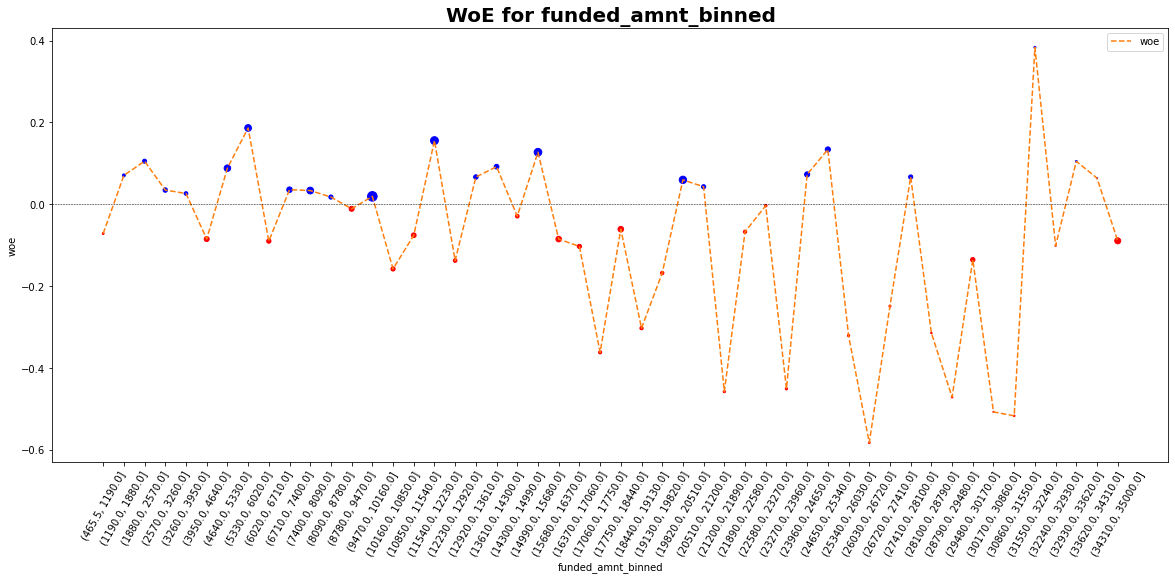

In [322]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.astype({woe_df.columns[0]: str}), ax=ax);
plt.xticks(rotation=60);

No clear pattern and there seems to be no association whatsoever with the dependant variable. In other words, this variable does not seem important to be used as an effective predictor for predicting probability of default.

## annual_inc

In [323]:
base_col = 'annual_inc'

In [324]:
df[f'{base_col}_binned'] = pd.cut(df[base_col], 50)

In [325]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_binned'], df['good_bad_loan'], {0: 'bad', 1: 'good'})
woe_df.sort_values(woe_df.columns[0], inplace=True)
woe_df

/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,annual_inc_binned,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
1,"(-2695.2, 154704.0]",89203,0.886506,0.113494,79079.0,10124.0,0.954714,0.970941,-0.016853,0.386506,2.055539,inf
2,"(154704.0, 304608.0]",3626,0.923883,0.076117,3350.0,276.0,0.040444,0.026470,0.423923,0.037377,0.440776,inf
3,"(304608.0, 454512.0]",282,0.925532,0.074468,261.0,21.0,0.003151,0.002014,0.447606,0.001649,0.023683,inf
6,"(454512.0, 604416.0]",86,0.965116,0.034884,83.0,3.0,0.001002,0.000288,1.247837,0.008595,0.229186,inf
5,"(604416.0, 754320.0]",23,0.956522,0.043478,22.0,1.0,0.000266,0.000096,1.018651,0.012077,0.257829,inf
4,"(754320.0, 904224.0]",18,0.944444,0.055556,17.0,1.0,0.000205,0.000096,0.760822,0.018913,0.313215,inf
7,"(904224.0, 1054128.0]",7,1.000000,0.000000,7.0,0.0,0.000085,0.000000,inf,0.034884,inf,inf
8,"(1054128.0, 1204032.0]",6,1.000000,0.000000,6.0,0.0,0.000072,0.000000,inf,0.000000,NaN,inf
0,"(1204032.0, 1353936.0]",2,0.500000,0.500000,1.0,1.0,0.000012,0.000096,-2.072392,NaN,NaN,inf
9,"(1353936.0, 1503840.0]",2,1.000000,0.000000,2.0,0.0,0.000024,0.000000,inf,0.000000,NaN,inf


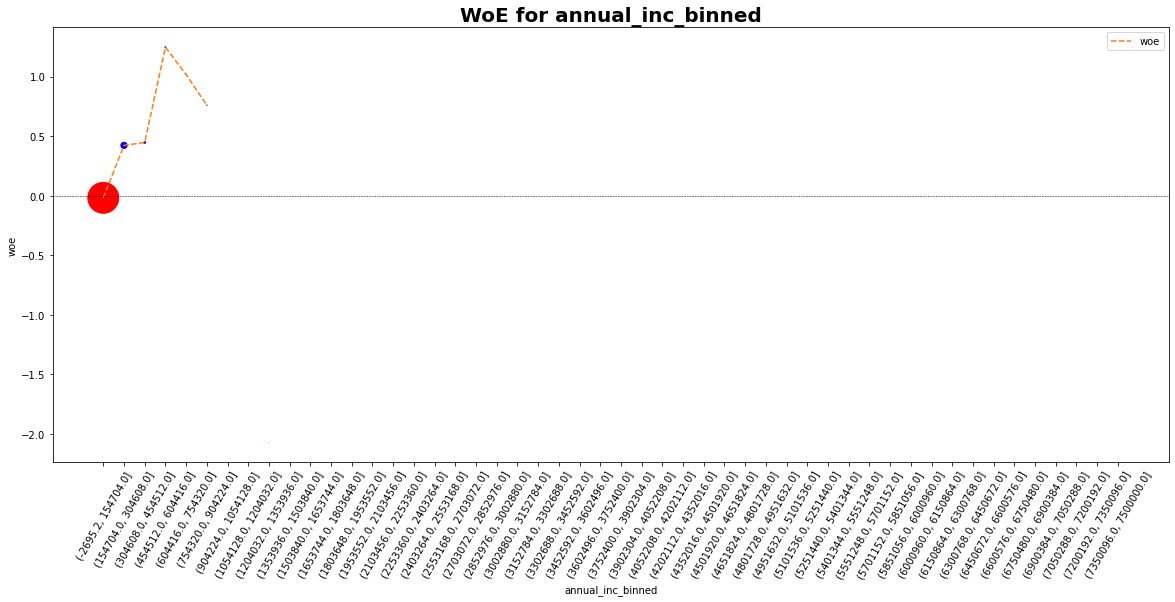

In [326]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.astype({woe_df.columns[0]: str}), ax=ax);
plt.xticks(rotation=60);

Looks like there are very less people with very high income, hence the bins that are cut were not appropriately

In [327]:
from sklearn.preprocessing import KBinsDiscretizer

dscrtzr = KBinsDiscretizer(n_bins=20, encode='ordinal')
df['annual_inc_binned'] = dscrtzr.fit_transform(df[['annual_inc']])
df['annual_inc_binned'].head()

362514    10.0
288564     9.0
213591    19.0
263083    10.0
165001    14.0
Name: annual_inc_binned, dtype: float64

In [328]:
lab_interval_map =  {i: pd._libs.interval.Interval(dscrtzr.bin_edges_[0][i], dscrtzr.bin_edges_[0][i+1]) for i in range(len(dscrtzr.bin_edges_[0]) - 1)}
lab_interval_map

{0: Interval(4800.0, 28000.0, closed='right'),
 1: Interval(28000.0, 33881.2, closed='right'),
 2: Interval(33881.2, 38000.0, closed='right'),
 3: Interval(38000.0, 41171.0, closed='right'),
 4: Interval(41171.0, 45000.0, closed='right'),
 5: Interval(45000.0, 49000.0, closed='right'),
 6: Interval(49000.0, 52000.0, closed='right'),
 7: Interval(52000.0, 55000.0, closed='right'),
 8: Interval(55000.0, 60000.0, closed='right'),
 9: Interval(60000.0, 63000.0, closed='right'),
 10: Interval(63000.0, 67000.0, closed='right'),
 11: Interval(67000.0, 71035.19999999998, closed='right'),
 12: Interval(71035.19999999998, 75200.0, closed='right'),
 13: Interval(75200.0, 81000.0, closed='right'),
 14: Interval(81000.0, 89000.0, closed='right'),
 15: Interval(89000.0, 96000.0, closed='right'),
 16: Interval(96000.0, 105000.0, closed='right'),
 17: Interval(105000.0, 120000.0, closed='right'),
 18: Interval(120000.0, 150000.0, closed='right'),
 19: Interval(150000.0, 7500000.0, closed='right')}

In [329]:
df['annual_inc_binned'] = df['annual_inc_binned'].map(lab_interval_map)

In [330]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_binned'], df['good_bad_loan'], {0: 'bad', 1: 'good'}, sorter_feat_func)
woe_df

,annual_inc_binned,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,"(4800.0, 28000.0]",4653,0.847410,0.152590,3943.0,710.0,0.047604,0.068092,-0.357960,NaN,NaN,0.054717
1,"(28000.0, 33881.2]",4673,0.850845,0.149155,3976.0,697.0,0.048002,0.066846,-0.331146,0.003435,0.026814,0.054717
2,"(33881.2, 38000.0]",4339,0.853653,0.146347,3704.0,635.0,0.044718,0.060900,-0.308848,0.002808,0.022297,0.054717
3,"(38000.0, 41171.0]",4986,0.868833,0.131167,4332.0,654.0,0.052300,0.062722,-0.181714,0.015180,0.127134,0.054717
4,"(41171.0, 45000.0]",3335,0.871664,0.128336,2907.0,428.0,0.035096,0.041047,-0.156638,0.002831,0.025076,0.054717
5,"(45000.0, 49000.0]",5628,0.874200,0.125800,4920.0,708.0,0.059399,0.067901,-0.133772,0.002536,0.022866,0.054717
6,"(49000.0, 52000.0]",4901,0.877168,0.122832,4299.0,602.0,0.051901,0.057735,-0.106511,0.002967,0.027261,0.054717
7,"(52000.0, 55000.0]",3208,0.875312,0.124688,2808.0,400.0,0.033901,0.038362,-0.123629,0.001856,0.017117,0.054717
8,"(55000.0, 60000.0]",5392,0.876113,0.123887,4724.0,668.0,0.057032,0.064064,-0.116269,0.000801,0.007360,0.054717
9,"(60000.0, 63000.0]",5395,0.879703,0.120297,4746.0,649.0,0.057298,0.062242,-0.082767,0.003591,0.033502,0.054717


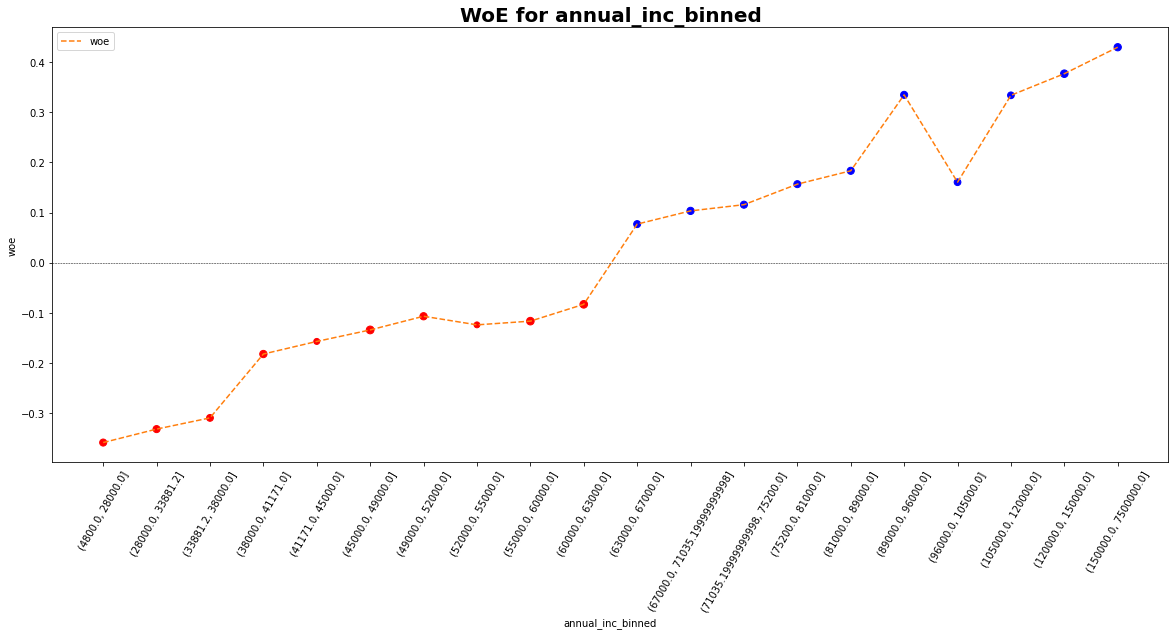

In [331]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.astype({woe_df.columns[0]: str}), ax=ax);
plt.xticks(rotation=60);

In [332]:
combined_cat_range = [(28000,),
                      (28000, 45000),
                      (45000, 49000),
                      (49000, 62983),
                      (62983, 67000),
                      (67000, 81000),
                      (81000, 105000),
                      (105000,)]


In [333]:
def get_category_name(cat_range, idx):
    cr = cat_range

    if (cr[0] == cr[-1]):
        if idx == 0:
            return f'<={cr[0]}'
        else:
            return f'>={cr[0]}'
    else:
        return f'{cr[0]}-{cr[-1]}'


In [334]:
cat_names = [get_category_name(cr, i) for i, cr in enumerate(combined_cat_range)]
cat_names

['<=28000',
 '28000-45000',
 '45000-49000',
 '49000-62983',
 '62983-67000',
 '67000-81000',
 '81000-105000',
 '>=105000']

In [335]:
def get_category(x, combined_cat_range):
    ccr = combined_cat_range
    n = len(ccr)
    for i, cr in enumerate(ccr):
        if i == 0:
            comp_res = x <= cr[0]
        elif i == (n - 1):
            comp_res = x >= cr[0]
        else:
            comp_res = (x >= cr[0]) and (x < cr[-1])
        
        if comp_res:
            return get_category_name(cr, i)
        

In [336]:
df[f'{base_col}_combined'] = df[base_col].apply(get_category, combined_cat_range=combined_cat_range)
df[f'{base_col}_combined'] = pd.Categorical(df[f'{base_col}_combined'], categories=cat_names, ordered=True)


In [337]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_combined'], df['good_bad_loan'], {0: 'bad', 1: 'good'}, sorter_feat_func)
woe_df

,annual_inc_combined,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,<=28000,5040,0.846825,0.153175,4268.0,772.0,0.051527,0.074039,-0.362476,NaN,NaN,0.052573
1,28000-45000,16946,0.861206,0.138794,14594.0,2352.0,0.176192,0.225568,-0.247047,0.014381,0.115428,0.052573
2,45000-49000,5628,0.874200,0.125800,4920.0,708.0,0.059399,0.067901,-0.133772,0.012994,0.113275,0.052573
3,49000-62983,18895,0.877269,0.122731,16576.0,2319.0,0.200121,0.222403,-0.105572,0.003069,0.028200,0.052573
4,62983-67000,4551,0.895627,0.104373,4076.0,475.0,0.049209,0.045555,0.077165,0.018358,0.182737,0.052573
5,67000-81000,14144,0.899958,0.100042,12729.0,1415.0,0.153676,0.135705,0.124362,0.004330,0.047197,0.052573
6,81000-105000,13591,0.908690,0.091310,12350.0,1241.0,0.149101,0.119018,0.225347,0.008732,0.100985,0.052573
7,>=105000,14462,0.920827,0.079173,13317.0,1145.0,0.160775,0.109811,0.381245,0.012137,0.155898,0.052573


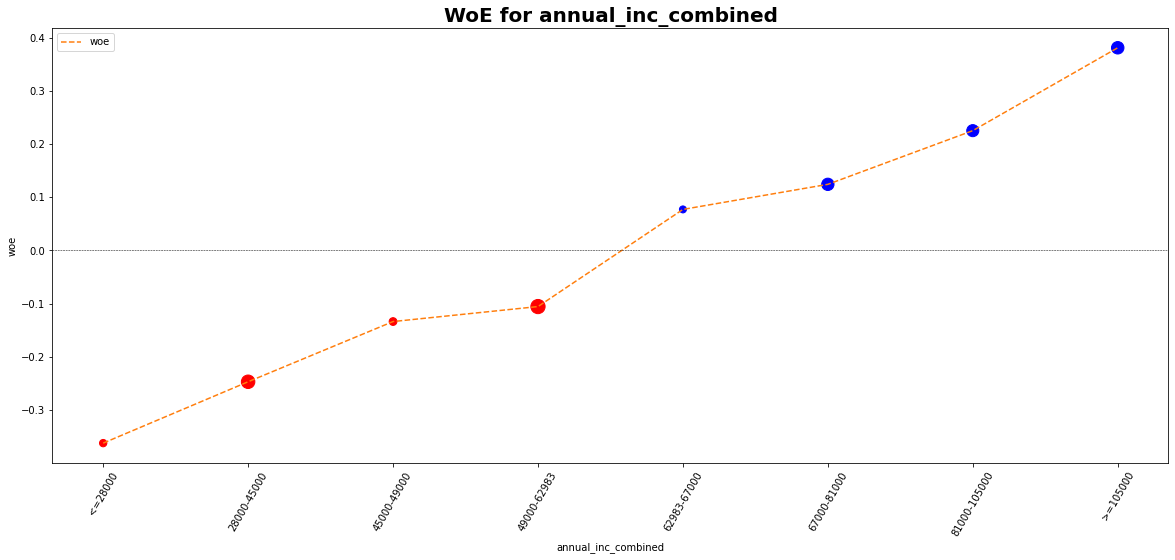

In [338]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.astype({woe_df.columns[0]: str}), ax=ax);
plt.xticks(rotation=60);

In [339]:
combined_cat_df = pd.get_dummies(df[f'{base_col}_combined'], prefix=base_col, prefix_sep=':')
combined_cat_df

,annual_inc:<=28000,annual_inc:28000-45000,annual_inc:45000-49000,annual_inc:49000-62983,annual_inc:62983-67000,annual_inc:67000-81000,annual_inc:81000-105000,annual_inc:>=105000
362514,0,0,0,0,1,0,0,0
288564,0,0,0,1,0,0,0,0
213591,0,0,0,0,0,0,0,1
263083,0,0,0,0,1,0,0,0
165001,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
115,0,1,0,0,0,0,0,0
296284,0,0,0,0,0,0,1,0
61777,0,0,0,0,0,0,0,1
91763,0,0,0,1,0,0,0,0


In [340]:
df = pd.concat([df, combined_cat_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,purpose:other__renewable_energy__medical__vacation__wedding,purpose:home_improvement__major_purchase__car,purpose_combined,term_int:36,term_int:60,emp_length_int_combined,emp_length_int:0,emp_length_int:1,emp_length_int:2-4,emp_length_int:5-6,emp_length_int:7-9,emp_length_int:10,mths_since_issue_d_binned,mths_since_issue_d_combined,mths_since_issue_d:<=38,mths_since_issue_d:38-40,mths_since_issue_d:40-42,mths_since_issue_d:42-49,mths_since_issue_d:49-53,mths_since_issue_d:53-65,mths_since_issue_d:65-85,mths_since_issue_d:>=85,int_rate_binned,int_rate_combined,int_rate:<=9.548,int_rate:9.548-12.025,int_rate:12.025-15.327,int_rate:15.327-19.868,int_rate:>=19.868,funded_amnt_binned,annual_inc_binned,annual_inc_combined,annual_inc:<=28000,annual_inc:28000-45000,annual_inc:45000-49000,annual_inc:49000-62983,annual_inc:62983-67000,annual_inc:67000-81000,annual_inc:81000-105000,annual_inc:>=105000
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,C5,Licensed vocational nurse,< 1 year,MORTGAGE,65000.0,Verified,2014-07-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,950xx,CA,9.32,0.0,2002-04-01,0.0,NaN,NaN,7.0,0.0,1208,4.3,20.0,f,0.00,0.00,38213.56000,...,0,1,home_improvement__major_purchase__car,0,1,0,1,0,0,0,0,0,"(39.6, 41.4]",40-42,0,0,1,0,0,0,0,0,"(14.914, 15.327]",12.025-15.327,0,0,1,0,0,"(32240.0, 32930.0]","(63000.0, 67000.0]",62983-67000,0,0,0,0,1,0,0,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,E4,shift manager,10+ years,MORTGAGE,60000.0,Verified,2014-10-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,472xx,IN,24.19,1.0,2003-08-01,0.0,3.0,NaN,18.0,0.0,13129,54.7,43.0,w,9214.67,9214.67,4450.12000,...,0,0,credit_card,0,1,10,0,0,0,0,0,1,"(37.8, 39.6]",<=38,1,0,0,0,0,0,0,0,"(20.694, 21.106]",>=19.868,0,0,0,0,1,"(10850.0, 11540.0]","(60000.0, 63000.0]",49000-62983,0,0,0,1,0,0,0,0
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,C2,FastMed urgent care,1 year,MORTGAGE,175000.0,Verified,2012-06-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/06/12 > I am seeking a de...,debt_consolidation,Debt Consolidation,852xx,AZ,13.34,0.0,2002-03-01,0.0,41.0,NaN,9.0,0.0,1906,22.4,38.0,f,0.00,0.00,32388.64000,...,0,0,debt_consolidation,1,0,1,0,1,0,0,0,0,"(64.8, 66.6]",65-85,0,0,0,0,0,0,1,0,"(14.502, 14.914]",12.025-15.327,0,0,1,0,0,"(29480.0, 30170.0]","(150000.0, 7500000.0]",>=105000,0,0,0,0,0,0,0,1
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,C4,Registered Nurse,2 years,MORTGAGE,66000.0,Source Verified,2014-11-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,498xx,MI,17.69,0.0,2008-08-01,0.0,NaN,NaN,12.0,0.0,12944,74.4,31.0,w,11901.76,11901.76,4719.18000,...,0,0,debt_consolidation,0,1,2-4,0,0,1,0,0,0,"(35.91, 37.8]",<=38,1,0,0,0,0,0,0,0,"(14.089, 14.502]",12.025-15.327,0,0,1,0,0,"(14300.0, 14990.0]","(63000.0, 67000.0]",62983-67000,0,0,0,0,1,0,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,A5,Courier Times,10+ years,MORTGAGE,85000.0,Verified,2013-02-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 02/06/13 > I need to cosolid...,debt_consolidation,Consolidate 2013,190xx,PA,8.30,0.0,1986-10-01,0.0,39.0,NaN,7.0,0.0,5902,67.8,20.0,f,0.00,0.00,16628.33315,...,0,0,debt_consolidation,1,0,10,0,0,0,0,0,1,"(57.6, 59.4]",53-65,0,0,0,0,0,

In [341]:
DUMMY_VARIABLES[base_col] = list(combined_cat_df.columns.str.replace(f'{base_col}:', ''))
DUMMY_VARIABLES

{'annual_inc': ['<=28000',
  '28000-45000',
  '45000-49000',
  '49000-62983',
  '62983-67000',
  '67000-81000',
  '81000-105000',
  '>=105000'],
 'emp_length_int': ['0', '1', '2-4', '5-6', '7-9', '10'],
 'grade': ['G', 'F', 'E', 'D', 'C', 'B', 'A'],
 'home_ownership': ['OTHER__NONE__ANY__RENT', 'OWN', 'MORTGAGE'],
 'initial_list_status': ['f', 'w'],
 'int_rate': ['<=9.548',
  '9.548-12.025',
  '12.025-15.327',
  '15.327-19.868',
  '>=19.868'],
 'mths_since_issue_d': ['<=38',
  '38-40',
  '40-42',
  '42-49',
  '49-53',
  '53-65',
  '65-85',
  '>=85'],
 'purpose': ['small_business__educational__moving__house',
  'other__renewable_energy__medical__vacation__wedding',
  'debt_consolidation',
  'home_improvement__major_purchase__car',
  'credit_card'],
 'term_int': [36, 60],
 'verification_status': ['Verified', 'Source Verified', 'Not Verified']}

## mths_since_last_delinq

In [342]:
base_col = 'mths_since_last_delinq'

In [343]:
def sorter_feat_func(d):
    return d.iloc[:, 0]

In [344]:
df[f'{base_col}_binned'] = pd.cut(df[base_col], 50)


In [345]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_binned'], df['good_bad_loan'], {0: 'bad', 1: 'good'}, sorter_feat_func)
woe_df

/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,mths_since_last_delinq_binned,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,"(-0.17, 3.4]",1348,0.867211,0.132789,1169.0,179.0,0.030556,0.037029,-0.192134,NaN,NaN,inf
1,"(3.4, 6.8]",1890,0.874603,0.125397,1653.0,237.0,0.043208,0.049028,-0.126365,0.007392,0.065769,inf
2,"(6.8, 10.2]",3373,0.882894,0.117106,2978.0,395.0,0.077842,0.081713,-0.048531,0.008290,0.077834,inf
3,"(10.2, 13.6]",2496,0.890625,0.109375,2223.0,273.0,0.058107,0.056475,0.028489,0.007731,0.077020,inf
4,"(13.6, 17.0]",3165,0.880885,0.119115,2788.0,377.0,0.072876,0.077989,-0.067818,0.009740,0.096307,inf
5,"(17.0, 20.4]",2282,0.888694,0.111306,2028.0,254.0,0.053010,0.052544,0.008819,0.007809,0.076637,inf
6,"(20.4, 23.8]",2115,0.895981,0.104019,1895.0,220.0,0.049533,0.045511,0.084694,0.007287,0.075875,inf
7,"(23.8, 27.2]",2755,0.892559,0.107441,2459.0,296.0,0.064276,0.061233,0.048498,0.003422,0.036196,inf
8,"(27.2, 30.6]",1929,0.892691,0.107309,1722.0,207.0,0.045011,0.042822,0.049871,0.000132,0.001372,inf
9,"(30.6, 34.0]",2453,0.889523,0.110477,2182.0,271.0,0.057035,0.056061,0.017226,0.003167,0.032645,inf


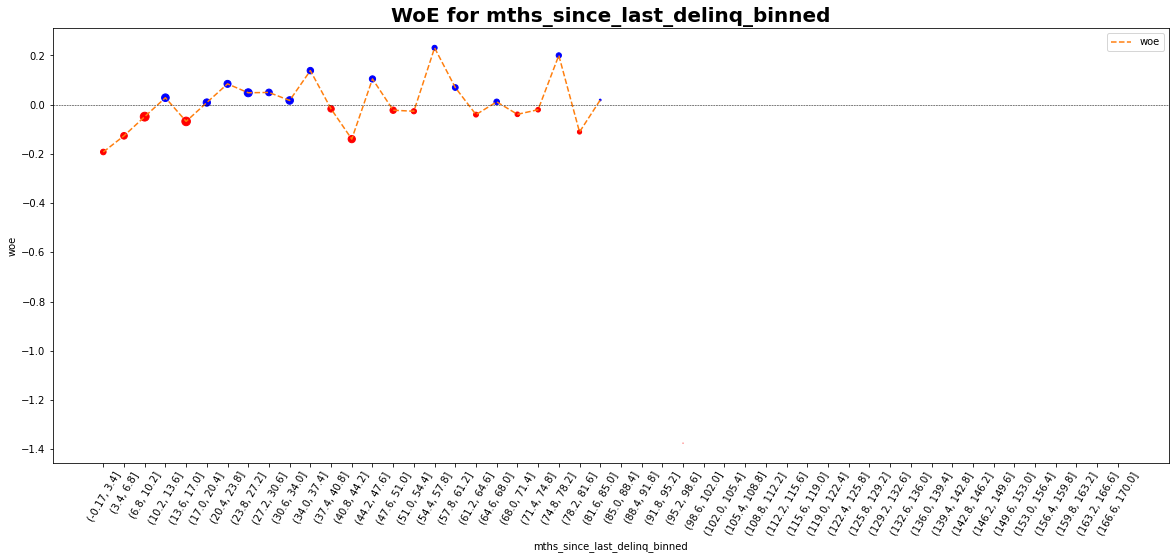

In [346]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.astype({woe_df.columns[0]: str}), ax=ax);
plt.xticks(rotation=60);

In [347]:
combined_cat_range = [(0, 4),
                      (4, 31),
                      (31, 57),
                      (57,)]


In [348]:
def get_category_name(cat_range, idx):
    cr = cat_range

    if (cr[0] == cr[-1]):
        if idx == 0:
            return f'<={cr[0]}'
        else:
            return f'>={cr[0]}'
    else:
        return f'{cr[0]}-{cr[-1]}'


In [349]:
cat_names = [get_category_name(cr, i) for i, cr in enumerate(combined_cat_range)]
cat_names

['0-4', '4-31', '31-57', '>=57']

In [350]:
def get_category(x, combined_cat_range):
    ccr = combined_cat_range
    n = len(ccr)
    for i, cr in enumerate(ccr):
        if i == 0:
            comp_res = x <= cr[0]
        elif i == (n - 1):
            comp_res = x >= cr[0]
        else:
            comp_res = (x >= cr[0]) and (x < cr[-1])
        
        if comp_res:
            return get_category_name(cr, i)
        

In [351]:
df[f'{base_col}_combined'] = df[base_col].apply(get_category, combined_cat_range=combined_cat_range)
df[f'{base_col}_combined'] = pd.Categorical(df[f'{base_col}_combined'].fillna('missing'), categories=['missing'] + cat_names, ordered=True)


In [352]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_combined'], df['good_bad_loan'], {0: 'bad', 1: 'good'}, sorter_feat_func)
woe_df

,mths_since_last_delinq_combined,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,missing,51276,0.888525,0.111475,45560.0,5716.0,0.550042,0.548192,0.003369,NaN,NaN,0.002937
1,0-4,238,0.764706,0.235294,182.0,56.0,0.002197,0.005371,-0.893737,0.123819,0.897106,0.002937
2,4-31,20005,0.887078,0.112922,17746.0,2259.0,0.214246,0.216649,-0.011154,0.122372,0.882583,0.002937
3,31-57,13592,0.889347,0.110653,12088.0,1504.0,0.145937,0.144241,0.011693,0.002268,0.022847,0.002937
4,>=57,8146,0.890498,0.109502,7254.0,892.0,0.087577,0.085547,0.023450,0.001152,0.011757,0.002937


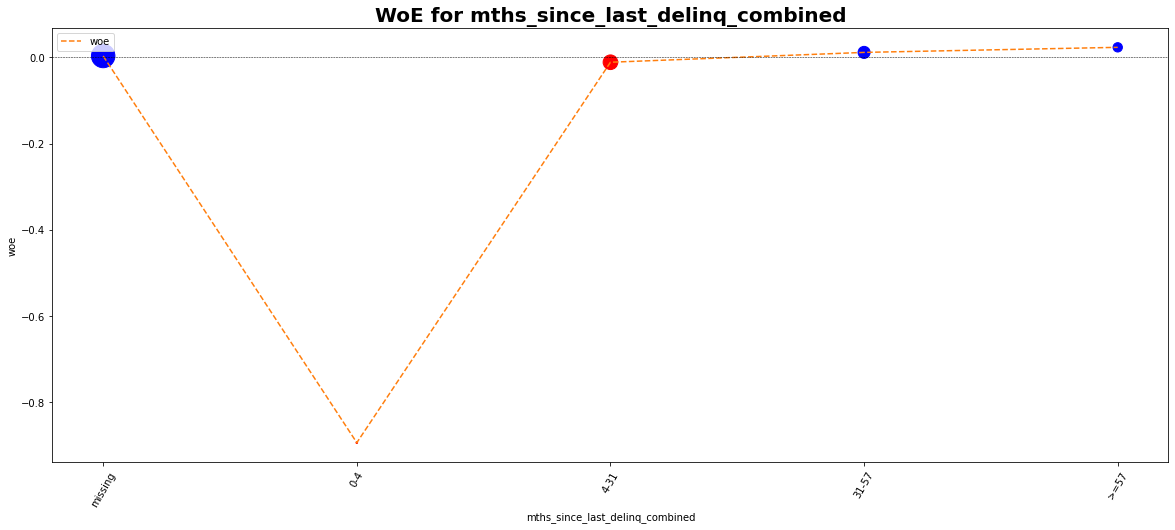

In [353]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.astype({woe_df.columns[0]: str}), ax=ax);
plt.xticks(rotation=60);

In [354]:
combined_cat_df = pd.get_dummies(df[f'{base_col}_combined'], prefix=base_col, prefix_sep=':')
combined_cat_df

,mths_since_last_delinq:missing,mths_since_last_delinq:0-4,mths_since_last_delinq:4-31,mths_since_last_delinq:31-57,mths_since_last_delinq:>=57
362514,1,0,0,0,0
288564,1,0,0,0,0
213591,0,0,0,1,0
263083,1,0,0,0,0
165001,0,0,0,1,0
...,...,...,...,...,...
115,1,0,0,0,0
296284,0,0,0,0,1
61777,1,0,0,0,0
91763,1,0,0,0,0


In [355]:
df = pd.concat([df, combined_cat_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,emp_length_int:1,emp_length_int:2-4,emp_length_int:5-6,emp_length_int:7-9,emp_length_int:10,mths_since_issue_d_binned,mths_since_issue_d_combined,mths_since_issue_d:<=38,mths_since_issue_d:38-40,mths_since_issue_d:40-42,mths_since_issue_d:42-49,mths_since_issue_d:49-53,mths_since_issue_d:53-65,mths_since_issue_d:65-85,mths_since_issue_d:>=85,int_rate_binned,int_rate_combined,int_rate:<=9.548,int_rate:9.548-12.025,int_rate:12.025-15.327,int_rate:15.327-19.868,int_rate:>=19.868,funded_amnt_binned,annual_inc_binned,annual_inc_combined,annual_inc:<=28000,annual_inc:28000-45000,annual_inc:45000-49000,annual_inc:49000-62983,annual_inc:62983-67000,annual_inc:67000-81000,annual_inc:81000-105000,annual_inc:>=105000,mths_since_last_delinq_binned,mths_since_last_delinq_combined,mths_since_last_delinq:missing,mths_since_last_delinq:0-4,mths_since_last_delinq:4-31,mths_since_last_delinq:31-57,mths_since_last_delinq:>=57
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,C5,Licensed vocational nurse,< 1 year,MORTGAGE,65000.0,Verified,2014-07-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,950xx,CA,9.32,0.0,2002-04-01,0.0,NaN,NaN,7.0,0.0,1208,4.3,20.0,f,0.00,0.00,38213.56000,...,0,0,0,0,0,"(39.6, 41.4]",40-42,0,0,1,0,0,0,0,0,"(14.914, 15.327]",12.025-15.327,0,0,1,0,0,"(32240.0, 32930.0]","(63000.0, 67000.0]",62983-67000,0,0,0,0,1,0,0,0,NaN,missing,1,0,0,0,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,E4,shift manager,10+ years,MORTGAGE,60000.0,Verified,2014-10-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,472xx,IN,24.19,1.0,2003-08-01,0.0,3.0,NaN,18.0,0.0,13129,54.7,43.0,w,9214.67,9214.67,4450.12000,...,0,0,0,0,1,"(37.8, 39.6]",<=38,1,0,0,0,0,0,0,0,"(20.694, 21.106]",>=19.868,0,0,0,0,1,"(10850.0, 11540.0]","(60000.0, 63000.0]",49000-62983,0,0,0,1,0,0,0,0,"(-0.17, 3.4]",missing,1,0,0,0,0
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,C2,FastMed urgent care,1 year,MORTGAGE,175000.0,Verified,2012-06-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/06/12 > I am seeking a de...,debt_consolidation,Debt Consolidation,852xx,AZ,13.34,0.0,2002-03-01,0.0,41.0,NaN,9.0,0.0,1906,22.4,38.0,f,0.00,0.00,32388.64000,...,1,0,0,0,0,"(64.8, 66.6]",65-85,0,0,0,0,0,0,1,0,"(14.502, 14.914]",12.025-15.327,0,0,1,0,0,"(29480.0, 30170.0]","(150000.0, 7500000.0]",>=105000,0,0,0,0,0,0,0,1,"(40.8, 44.2]",31-57,0,0,0,1,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,C4,Registered Nurse,2 years,MORTGAGE,66000.0,Source Verified,2014-11-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,498xx,MI,17.69,0.0,2008-08-01,0.0,NaN,NaN,12.0,0.0,12944,74.4,31.0,w,11901.76,11901.76,4719.18000,...,0,1,0,0,0,"(35.91, 37.8]",<=38,1,0,0,0,0,0,0,0,"(14.089, 14.502]",12.025-15.327,0,0,1,0,0,"(14300.0, 14990.0]","(63000.0, 67000.0]",62983-67000,0,0,0,0,1,0,0,0,NaN,missing,1,0,0,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,A5,Courier Times,10+ years,MORTGAGE,85000.0,Verified,2013-02-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 02/06/13 > I need to cosolid...,debt_consolidation,Consolidate 2013,190xx,PA,8.30,0.0,1986-10-01,0.0,39.0,NaN,7.0,0.0,5902,67.8,20.0,f,0.00,0.00,16628.33315,...,0,0,0,0,1,"(57.6, 59.4]",53-65,0,0,0,0,0,1,0,0,"(8.722, 9.135]",<=9.548,1,0,0,0,0,"(149

In [356]:
DUMMY_VARIABLES[base_col] = list(combined_cat_df.columns.str.replace(f'{base_col}:', ''))
DUMMY_VARIABLES

{'annual_inc': ['<=28000',
  '28000-45000',
  '45000-49000',
  '49000-62983',
  '62983-67000',
  '67000-81000',
  '81000-105000',
  '>=105000'],
 'emp_length_int': ['0', '1', '2-4', '5-6', '7-9', '10'],
 'grade': ['G', 'F', 'E', 'D', 'C', 'B', 'A'],
 'home_ownership': ['OTHER__NONE__ANY__RENT', 'OWN', 'MORTGAGE'],
 'initial_list_status': ['f', 'w'],
 'int_rate': ['<=9.548',
  '9.548-12.025',
  '12.025-15.327',
  '15.327-19.868',
  '>=19.868'],
 'mths_since_issue_d': ['<=38',
  '38-40',
  '40-42',
  '42-49',
  '49-53',
  '53-65',
  '65-85',
  '>=85'],
 'mths_since_last_delinq': ['missing', '0-4', '4-31', '31-57', '>=57'],
 'purpose': ['small_business__educational__moving__house',
  'other__renewable_energy__medical__vacation__wedding',
  'debt_consolidation',
  'home_improvement__major_purchase__car',
  'credit_card'],
 'term_int': [36, 60],
 'verification_status': ['Verified', 'Source Verified', 'Not Verified']}

## dti

In [357]:
base_col = 'dti'

In [358]:
df[f'{base_col}_binned'] = pd.cut(df['dti'], 100)

In [359]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_binned'], df['good_bad_loan'], {0: 'bad', 1: 'good'}, sorter_feat_func)
woe_df

,dti_binned,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,"(-0.04, 0.4]",187,0.893048,0.106952,167.0,20.0,0.002016,0.001918,0.049870,NaN,NaN,0.038023
1,"(0.4, 0.8]",184,0.880435,0.119565,162.0,22.0,0.001956,0.002110,-0.075838,0.012613,0.125708,0.038023
2,"(0.8, 1.2]",223,0.892377,0.107623,199.0,24.0,0.002403,0.002302,0.042859,0.011942,0.118697,0.038023
3,"(1.2, 1.6]",255,0.905882,0.094118,231.0,24.0,0.002789,0.002302,0.191972,0.013506,0.149113,0.038023
4,"(1.6, 2.0]",315,0.892063,0.107937,281.0,34.0,0.003392,0.003261,0.039602,0.013819,0.152370,0.038023
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(37.991, 38.39]",54,0.888889,0.111111,48.0,6.0,0.000580,0.000575,0.007050,0.044444,0.387766,0.038023
96,"(38.39, 38.79]",37,0.837838,0.162162,31.0,6.0,0.000374,0.000575,-0.430164,0.051051,0.437214,0.038023
97,"(38.79, 39.19]",45,0.822222,0.177778,37.0,8.0,0.000447,0.000767,-0.540915,0.015616,0.110751,0.038023
98,"(39.19, 39.59]",44,0.909091,0.090909,40.0,4.0,0.000483,0.000384,0.230193,0.086869,0.771109,0.038023


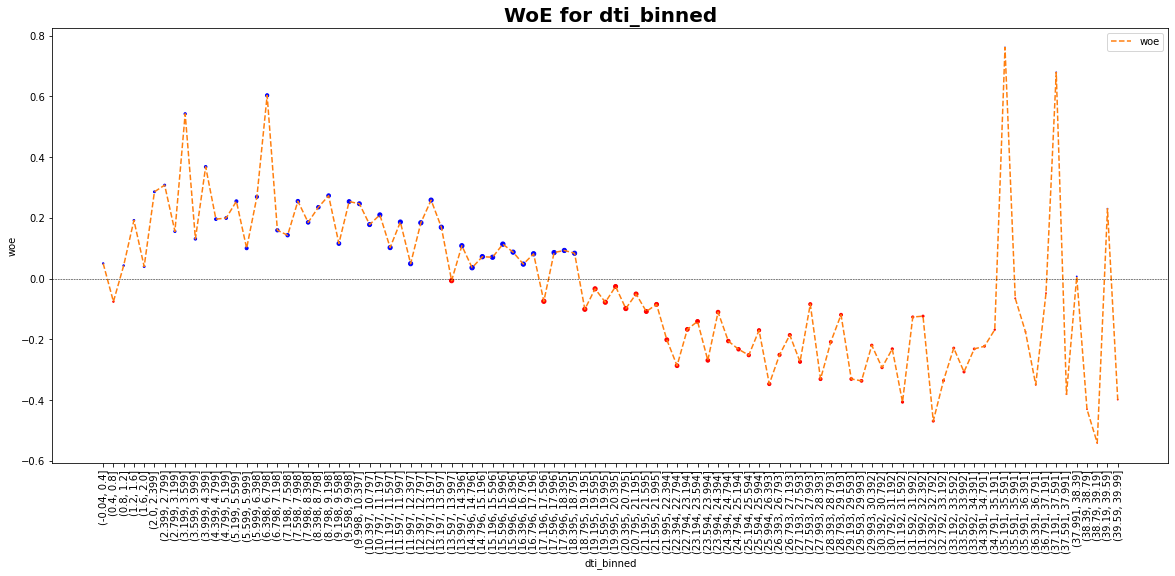

In [360]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.astype({woe_df.columns[0]: str}), ax=ax);
plt.xticks(rotation=90);

In [361]:
combined_cat_range = [(7.598,),
                      (7.598, 11.997),
                      (11.997, 16.796),
                      (16.796, 21.595),
                      (21.595, 25.994),
                      (25.994,)]


In [362]:
def get_category_name(cat_range, idx):
    cr = cat_range

    if (cr[0] == cr[-1]):
        if idx == 0:
            return f'<={cr[0]}'
        else:
            return f'>={cr[0]}'
    else:
        return f'{cr[0]}-{cr[-1]}'


In [363]:
cat_names = [get_category_name(cr, i) for i, cr in enumerate(combined_cat_range)]
cat_names

['<=7.598',
 '7.598-11.997',
 '11.997-16.796',
 '16.796-21.595',
 '21.595-25.994',
 '>=25.994']

In [364]:
def get_category(x, combined_cat_range):
    ccr = combined_cat_range
    n = len(ccr)
    for i, cr in enumerate(ccr):
        if i == 0:
            comp_res = x <= cr[0]
        elif i == (n - 1):
            comp_res = x >= cr[0]
        else:
            comp_res = (x >= cr[0]) and (x < cr[-1])
        
        if comp_res:
            return get_category_name(cr, i)
        

In [365]:
df[f'{base_col}_combined'] = df[base_col].apply(get_category, combined_cat_range=combined_cat_range)
df[f'{base_col}_combined'] = pd.Categorical(df[f'{base_col}_combined'], categories=cat_names, ordered=True)


In [366]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_combined'], df['good_bad_loan'], {0: 'bad', 1: 'good'}, sorter_feat_func)
woe_df

,dti_combined,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,<=7.598,10916,0.908941,0.091059,9922.0,994.0,0.119788,0.095329,0.228381,NaN,NaN,0.029448
1,7.598-11.997,15086,0.906536,0.093464,13676.0,1410.0,0.165109,0.135226,0.199661,0.002405,0.028720,0.029448
2,11.997-16.796,20405,0.897427,0.102573,18312.0,2093.0,0.221079,0.200729,0.096566,0.009109,0.103095,0.029448
3,16.796-21.595,19432,0.886270,0.113730,17222.0,2210.0,0.207920,0.211950,-0.019197,0.011157,0.115763,0.029448
4,21.595-25.994,13461,0.867692,0.132308,11680.0,1781.0,0.141012,0.170807,-0.191689,0.018578,0.172492,0.029448
5,>=25.994,13957,0.861073,0.138927,12018.0,1939.0,0.145092,0.185960,-0.248159,0.006619,0.056470,0.029448


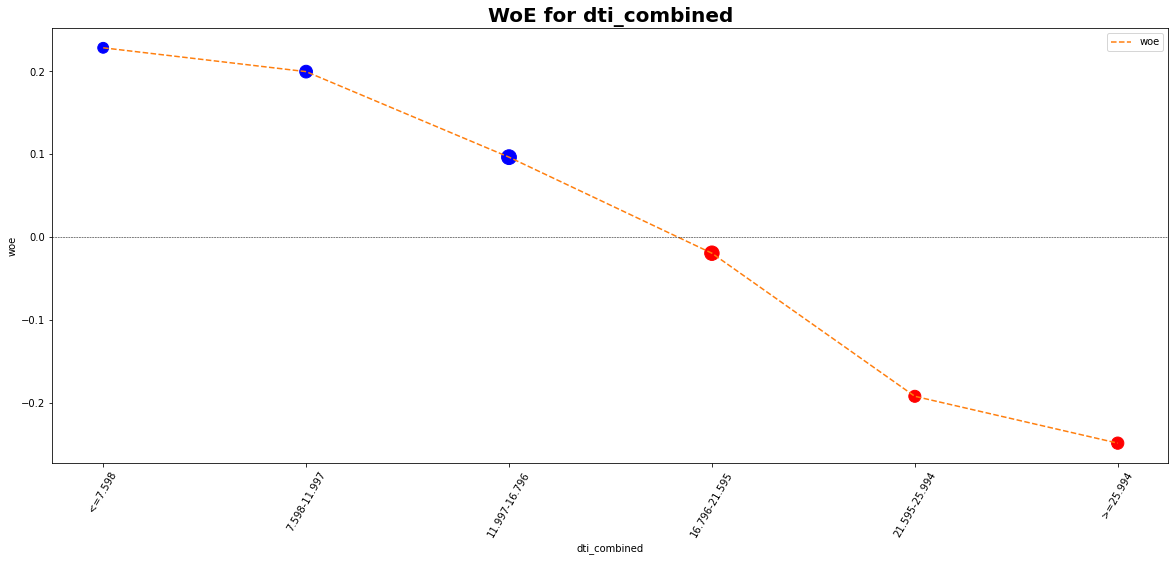

In [367]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.astype({woe_df.columns[0]: str}), ax=ax);
plt.xticks(rotation=60);

In [368]:
combined_cat_df = pd.get_dummies(df[f'{base_col}_combined'], prefix=base_col, prefix_sep=':')
combined_cat_df

,dti:<=7.598,dti:7.598-11.997,dti:11.997-16.796,dti:16.796-21.595,dti:21.595-25.994,dti:>=25.994
362514,0,1,0,0,0,0
288564,0,0,0,0,1,0
213591,0,0,1,0,0,0
263083,0,0,0,1,0,0
165001,0,1,0,0,0,0
...,...,...,...,...,...,...
115,0,1,0,0,0,0
296284,0,0,0,1,0,0
61777,0,1,0,0,0,0
91763,0,0,1,0,0,0


In [369]:
df = pd.concat([df, combined_cat_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,mths_since_issue_d:38-40,mths_since_issue_d:40-42,mths_since_issue_d:42-49,mths_since_issue_d:49-53,mths_since_issue_d:53-65,mths_since_issue_d:65-85,mths_since_issue_d:>=85,int_rate_binned,int_rate_combined,int_rate:<=9.548,int_rate:9.548-12.025,int_rate:12.025-15.327,int_rate:15.327-19.868,int_rate:>=19.868,funded_amnt_binned,annual_inc_binned,annual_inc_combined,annual_inc:<=28000,annual_inc:28000-45000,annual_inc:45000-49000,annual_inc:49000-62983,annual_inc:62983-67000,annual_inc:67000-81000,annual_inc:81000-105000,annual_inc:>=105000,mths_since_last_delinq_binned,mths_since_last_delinq_combined,mths_since_last_delinq:missing,mths_since_last_delinq:0-4,mths_since_last_delinq:4-31,mths_since_last_delinq:31-57,mths_since_last_delinq:>=57,dti_binned,dti_combined,dti:<=7.598,dti:7.598-11.997,dti:11.997-16.796,dti:16.796-21.595,dti:21.595-25.994,dti:>=25.994
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,C5,Licensed vocational nurse,< 1 year,MORTGAGE,65000.0,Verified,2014-07-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,950xx,CA,9.32,0.0,2002-04-01,0.0,NaN,NaN,7.0,0.0,1208,4.3,20.0,f,0.00,0.00,38213.56000,...,0,1,0,0,0,0,0,"(14.914, 15.327]",12.025-15.327,0,0,1,0,0,"(32240.0, 32930.0]","(63000.0, 67000.0]",62983-67000,0,0,0,0,1,0,0,0,NaN,missing,1,0,0,0,0,"(9.198, 9.598]",7.598-11.997,0,1,0,0,0,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,E4,shift manager,10+ years,MORTGAGE,60000.0,Verified,2014-10-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,472xx,IN,24.19,1.0,2003-08-01,0.0,3.0,NaN,18.0,0.0,13129,54.7,43.0,w,9214.67,9214.67,4450.12000,...,0,0,0,0,0,0,0,"(20.694, 21.106]",>=19.868,0,0,0,0,1,"(10850.0, 11540.0]","(60000.0, 63000.0]",49000-62983,0,0,0,1,0,0,0,0,"(-0.17, 3.4]",missing,1,0,0,0,0,"(23.994, 24.394]",21.595-25.994,0,0,0,0,1,0
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,C2,FastMed urgent care,1 year,MORTGAGE,175000.0,Verified,2012-06-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/06/12 > I am seeking a de...,debt_consolidation,Debt Consolidation,852xx,AZ,13.34,0.0,2002-03-01,0.0,41.0,NaN,9.0,0.0,1906,22.4,38.0,f,0.00,0.00,32388.64000,...,0,0,0,0,0,1,0,"(14.502, 14.914]",12.025-15.327,0,0,1,0,0,"(29480.0, 30170.0]","(150000.0, 7500000.0]",>=105000,0,0,0,0,0,0,0,1,"(40.8, 44.2]",31-57,0,0,0,1,0,"(13.197, 13.597]",11.997-16.796,0,0,1,0,0,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,C4,Registered Nurse,2 years,MORTGAGE,66000.0,Source Verified,2014-11-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,498xx,MI,17.69,0.0,2008-08-01,0.0,NaN,NaN,12.0,0.0,12944,74.4,31.0,w,11901.76,11901.76,4719.18000,...,0,0,0,0,0,0,0,"(14.089, 14.502]",12.025-15.327,0,0,1,0,0,"(14300.0, 14990.0]","(63000.0, 67000.0]",62983-67000,0,0,0,0,1,0,0,0,NaN,missing,1,0,0,0,0,"(17.596, 17.996]",16.796-21.595,0,0,0,1,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,A5,Courier Times,10+ years,MORTGAGE,85000.0,Verified,2013-02-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 02/06/13 > I need to cosolid...,debt_consolidation,Consolidate 2013,190xx,PA,8.30,0.0,1986-10-01,0.0,39.0,NaN,7.0,0.0,5902,67.8,20.0,f,0.00,0.00,16628.33315,...,0,0,0,0,1,0,0,"(8.722, 9.135]",<=9.548,1,0,0,0,0,"(14990.0, 15680.0]","(81000.0, 89000.0]",

In [370]:
DUMMY_VARIABLES[base_col] = list(combined_cat_df.columns.str.replace(f'{base_col}:', ''))
DUMMY_VARIABLES

{'annual_inc': ['<=28000',
  '28000-45000',
  '45000-49000',
  '49000-62983',
  '62983-67000',
  '67000-81000',
  '81000-105000',
  '>=105000'],
 'dti': ['<=7.598',
  '7.598-11.997',
  '11.997-16.796',
  '16.796-21.595',
  '21.595-25.994',
  '>=25.994'],
 'emp_length_int': ['0', '1', '2-4', '5-6', '7-9', '10'],
 'grade': ['G', 'F', 'E', 'D', 'C', 'B', 'A'],
 'home_ownership': ['OTHER__NONE__ANY__RENT', 'OWN', 'MORTGAGE'],
 'initial_list_status': ['f', 'w'],
 'int_rate': ['<=9.548',
  '9.548-12.025',
  '12.025-15.327',
  '15.327-19.868',
  '>=19.868'],
 'mths_since_issue_d': ['<=38',
  '38-40',
  '40-42',
  '42-49',
  '49-53',
  '53-65',
  '65-85',
  '>=85'],
 'mths_since_last_delinq': ['missing', '0-4', '4-31', '31-57', '>=57'],
 'purpose': ['small_business__educational__moving__house',
  'other__renewable_energy__medical__vacation__wedding',
  'debt_consolidation',
  'home_improvement__major_purchase__car',
  'credit_card'],
 'term_int': [36, 60],
 'verification_status': ['Verified', 

## mths_since_last_record

In [371]:
base_col = 'mths_since_last_record'

In [372]:
df[f'{base_col}_binned'] = pd.cut(df[base_col], 50)

In [373]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_binned'], df['good_bad_loan'], {0: 'bad', 1: 'good'}, sorter_feat_func)
woe_df

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mths_since_last_record_binned,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
0,"(-0.129, 2.58]",244,0.741803,0.258197,181.0,63.0,0.016096,0.047511,-1.082394,NaN,NaN,inf
1,"(2.58, 5.16]",36,0.888889,0.111111,32.0,4.0,0.002846,0.003017,-0.058315,0.147086,1.024079,inf
2,"(5.16, 7.74]",39,0.923077,0.076923,36.0,3.0,0.003201,0.002262,0.347150,0.034188,0.405465,inf
3,"(7.74, 10.32]",66,0.924242,0.075758,61.0,5.0,0.005425,0.003771,0.363679,0.001166,0.016529,inf
4,"(10.32, 12.9]",42,0.833333,0.166667,35.0,7.0,0.003112,0.005279,-0.528319,0.090909,0.891998,inf
5,"(12.9, 15.48]",69,0.869565,0.130435,60.0,9.0,0.005336,0.006787,-0.240637,0.036232,0.287682,inf
6,"(15.48, 18.06]",95,0.863158,0.136842,82.0,13.0,0.007292,0.009804,-0.295987,0.006407,0.055350,inf
7,"(18.06, 20.64]",58,0.965517,0.034483,56.0,2.0,0.004980,0.001508,1.194448,0.102359,1.490435,inf
8,"(20.64, 23.22]",101,0.881188,0.118812,89.0,12.0,0.007915,0.009050,-0.134027,0.084329,1.328475,inf
9,"(23.22, 25.8]",94,0.946809,0.053191,89.0,5.0,0.007915,0.003771,0.741442,0.065620,0.875469,inf


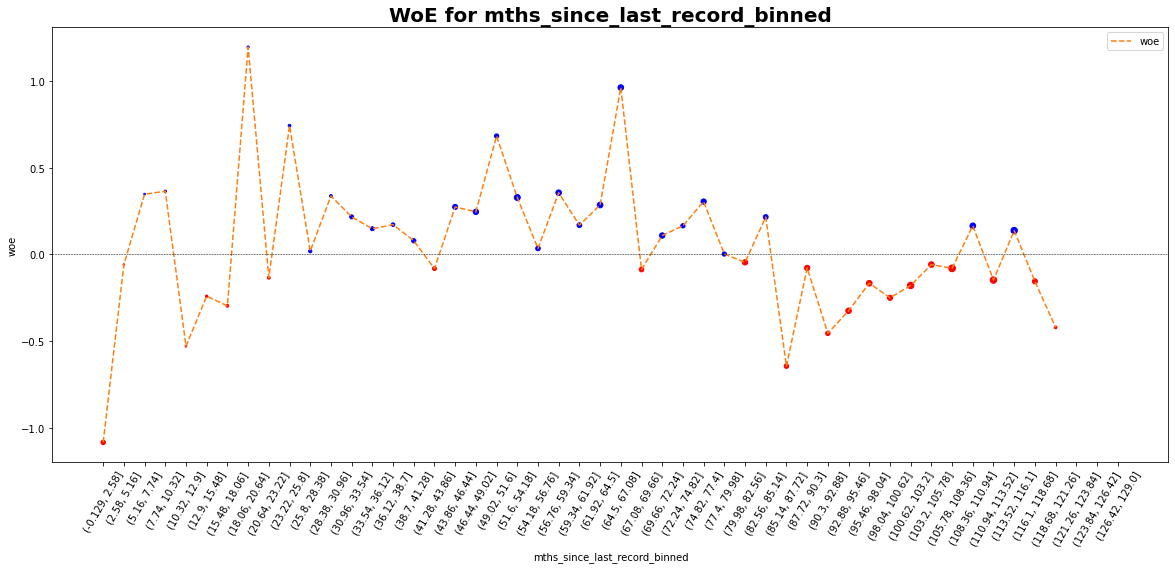

In [374]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.astype({woe_df.columns[0]: str}), ax=ax);
plt.xticks(rotation=60);

In [375]:
combined_cat_range = [(0, 2),
                      (2, 21),
                      (21, 32),
                      (32, 81),
                      (81, 87),
                      (87,)]


In [376]:
def get_category_name(cat_range, idx):
    cr = cat_range

    if (cr[0] == cr[-1]):
        if idx == 0:
            return f'<{cr[0]}'
        else:
            return f'>={cr[0]}'
    else:
        return f'{cr[0]}-{cr[-1]}'


In [377]:
cat_names = [get_category_name(cr, i) for i, cr in enumerate(combined_cat_range)]
cat_names

['0-2', '2-21', '21-32', '32-81', '81-87', '>=87']

In [378]:
def get_category(x, combined_cat_range):
    ccr = combined_cat_range
    n = len(ccr)
    for i, cr in enumerate(ccr):
        if i == 0:
            comp_res = x <= cr[0]
        elif i == (n - 1):
            comp_res = x >= cr[0]
        else:
            comp_res = (x >= cr[0]) and (x < cr[-1])
        
        if comp_res:
            return get_category_name(cr, i)
        

In [379]:
df[f'{base_col}_combined'] = df[base_col].apply(get_category, combined_cat_range=combined_cat_range)
df[f'{base_col}_combined'] = pd.Categorical(df[f'{base_col}_combined'].fillna('missing'), categories=['missing'] + cat_names, ordered=True)


In [380]:
woe_df = get_weight_of_evidence_stats(df[f'{base_col}_combined'], df['good_bad_loan'], {0: 'bad', 1: 'good'})
woe_df.sort_values(woe_df.columns[0], inplace=True)
woe_df

,mths_since_last_record_combined,n_obs,prop_good,prop_bad,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv
3,missing,80690,0.887210,0.112790,71589.0,9101.0,0.864288,0.872830,-0.009835,0.002773,0.027416,0.009832
0,0-2,237,0.738397,0.261603,175.0,62.0,0.002113,0.005946,-1.034740,NaN,NaN,0.009832
4,2-21,408,0.892157,0.107843,364.0,44.0,0.004395,0.004220,0.040573,0.004947,0.050407,0.009832
5,21-32,497,0.911469,0.088531,453.0,44.0,0.005469,0.004220,0.259311,0.019312,0.218738,0.009832
6,32-81,5599,0.915163,0.084837,5124.0,475.0,0.061862,0.045555,0.305984,0.003695,0.046673,0.009832
2,81-87,649,0.884438,0.115562,574.0,75.0,0.006930,0.007193,-0.037250,0.005357,0.051389,0.009832
1,>=87,5177,0.879081,0.120919,4551.0,626.0,0.054944,0.060036,-0.088640,0.140684,0.946100,0.009832


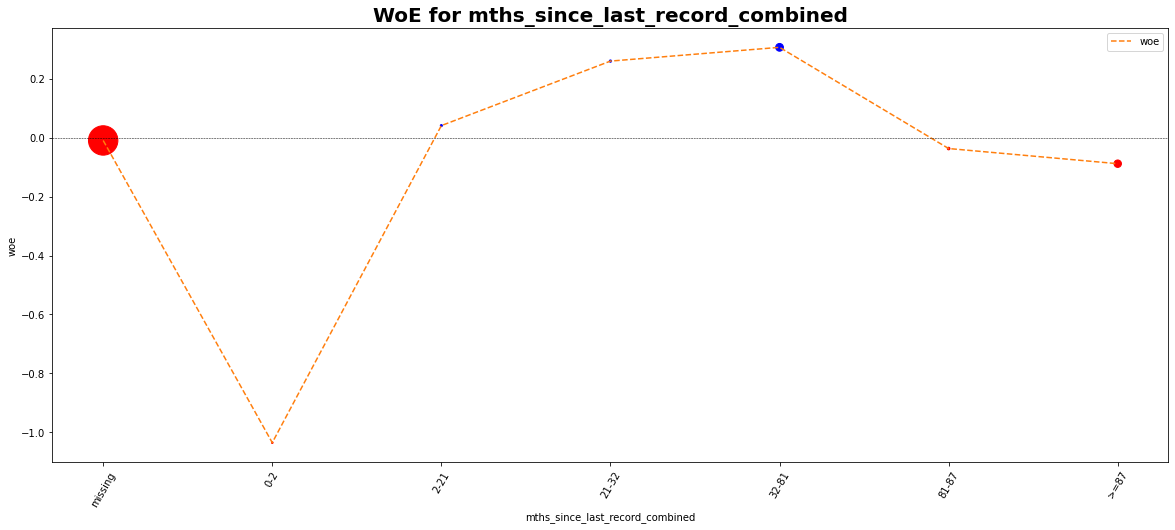

In [381]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_by_woe(woe_df.astype({woe_df.columns[0]: str}), ax=ax);
plt.xticks(rotation=60);

In [382]:
combined_cat_df = pd.get_dummies(df[f'{base_col}_combined'], prefix=base_col, prefix_sep=':')
combined_cat_df

,mths_since_last_record:missing,mths_since_last_record:0-2,mths_since_last_record:2-21,mths_since_last_record:21-32,mths_since_last_record:32-81,mths_since_last_record:81-87,mths_since_last_record:>=87
362514,1,0,0,0,0,0,0
288564,1,0,0,0,0,0,0
213591,1,0,0,0,0,0,0
263083,1,0,0,0,0,0,0
165001,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
115,1,0,0,0,0,0,0
296284,1,0,0,0,0,0,0
61777,1,0,0,0,0,0,0
91763,1,0,0,0,0,0,0


In [383]:
df = pd.concat([df, combined_cat_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,int_rate:<=9.548,int_rate:9.548-12.025,int_rate:12.025-15.327,int_rate:15.327-19.868,int_rate:>=19.868,funded_amnt_binned,annual_inc_binned,annual_inc_combined,annual_inc:<=28000,annual_inc:28000-45000,annual_inc:45000-49000,annual_inc:49000-62983,annual_inc:62983-67000,annual_inc:67000-81000,annual_inc:81000-105000,annual_inc:>=105000,mths_since_last_delinq_binned,mths_since_last_delinq_combined,mths_since_last_delinq:missing,mths_since_last_delinq:0-4,mths_since_last_delinq:4-31,mths_since_last_delinq:31-57,mths_since_last_delinq:>=57,dti_binned,dti_combined,dti:<=7.598,dti:7.598-11.997,dti:11.997-16.796,dti:16.796-21.595,dti:21.595-25.994,dti:>=25.994,mths_since_last_record_binned,mths_since_last_record_combined,mths_since_last_record:missing,mths_since_last_record:0-2,mths_since_last_record:2-21,mths_since_last_record:21-32,mths_since_last_record:32-81,mths_since_last_record:81-87,mths_since_last_record:>=87
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,C5,Licensed vocational nurse,< 1 year,MORTGAGE,65000.0,Verified,2014-07-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home improvement,950xx,CA,9.32,0.0,2002-04-01,0.0,NaN,NaN,7.0,0.0,1208,4.3,20.0,f,0.00,0.00,38213.56000,...,0,0,1,0,0,"(32240.0, 32930.0]","(63000.0, 67000.0]",62983-67000,0,0,0,0,1,0,0,0,NaN,missing,1,0,0,0,0,"(9.198, 9.598]",7.598-11.997,0,1,0,0,0,0,NaN,missing,1,0,0,0,0,0,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,E4,shift manager,10+ years,MORTGAGE,60000.0,Verified,2014-10-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,472xx,IN,24.19,1.0,2003-08-01,0.0,3.0,NaN,18.0,0.0,13129,54.7,43.0,w,9214.67,9214.67,4450.12000,...,0,0,0,0,1,"(10850.0, 11540.0]","(60000.0, 63000.0]",49000-62983,0,0,0,1,0,0,0,0,"(-0.17, 3.4]",missing,1,0,0,0,0,"(23.994, 24.394]",21.595-25.994,0,0,0,0,1,0,NaN,missing,1,0,0,0,0,0,0
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,C2,FastMed urgent care,1 year,MORTGAGE,175000.0,Verified,2012-06-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/06/12 > I am seeking a de...,debt_consolidation,Debt Consolidation,852xx,AZ,13.34,0.0,2002-03-01,0.0,41.0,NaN,9.0,0.0,1906,22.4,38.0,f,0.00,0.00,32388.64000,...,0,0,1,0,0,"(29480.0, 30170.0]","(150000.0, 7500000.0]",>=105000,0,0,0,0,0,0,0,1,"(40.8, 44.2]",31-57,0,0,0,1,0,"(13.197, 13.597]",11.997-16.796,0,0,1,0,0,0,NaN,missing,1,0,0,0,0,0,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,C4,Registered Nurse,2 years,MORTGAGE,66000.0,Source Verified,2014-11-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,498xx,MI,17.69,0.0,2008-08-01,0.0,NaN,NaN,12.0,0.0,12944,74.4,31.0,w,11901.76,11901.76,4719.18000,...,0,0,1,0,0,"(14300.0, 14990.0]","(63000.0, 67000.0]",62983-67000,0,0,0,0,1,0,0,0,NaN,missing,1,0,0,0,0,"(17.596, 17.996]",16.796-21.595,0,0,0,1,0,0,NaN,missing,1,0,0,0,0,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,A5,Courier Times,10+ years,MORTGAGE,85000.0,Verified,2013-02-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 02/06/13 > I need to cosolid...,debt_consolidation,Consolidate 2013,190xx,PA,8.30,0.0,1986-10-01,0.0,39.0,NaN,7.0,0.0,5902,67.8,20.0,f,0.00,0.00,16628.33315,...,1,0,0,0,0,"(14990.0, 15680.0]","(81000.0, 89000.0]",81000-105000,0,0,0,0,0,0,1,0,"(37.4, 40.8]",31-57,0,0,0,1,0,"(7

In [384]:
DUMMY_VARIABLES[base_col] = list(combined_cat_df.columns.str.replace(f'{base_col}:', ''))
DUMMY_VARIABLES

{'annual_inc': ['<=28000',
  '28000-45000',
  '45000-49000',
  '49000-62983',
  '62983-67000',
  '67000-81000',
  '81000-105000',
  '>=105000'],
 'dti': ['<=7.598',
  '7.598-11.997',
  '11.997-16.796',
  '16.796-21.595',
  '21.595-25.994',
  '>=25.994'],
 'emp_length_int': ['0', '1', '2-4', '5-6', '7-9', '10'],
 'grade': ['G', 'F', 'E', 'D', 'C', 'B', 'A'],
 'home_ownership': ['OTHER__NONE__ANY__RENT', 'OWN', 'MORTGAGE'],
 'initial_list_status': ['f', 'w'],
 'int_rate': ['<=9.548',
  '9.548-12.025',
  '12.025-15.327',
  '15.327-19.868',
  '>=19.868'],
 'mths_since_issue_d': ['<=38',
  '38-40',
  '40-42',
  '42-49',
  '49-53',
  '53-65',
  '65-85',
  '>=85'],
 'mths_since_last_delinq': ['missing', '0-4', '4-31', '31-57', '>=57'],
 'mths_since_last_record': ['missing',
  '0-2',
  '2-21',
  '21-32',
  '32-81',
  '81-87',
  '>=87'],
 'purpose': ['small_business__educational__moving__house',
  'other__renewable_energy__medical__vacation__wedding',
  'debt_consolidation',
  'home_improvement

## Restructure the data

In [385]:
dummy_var_lst_df = pd.DataFrame([DUMMY_VARIABLES]).T.explode(0).reset_index()
dummy_var_lst_df = pd.DataFrame(dummy_var_lst_df.iloc[:, 0] + ':' + dummy_var_lst_df.iloc[:, 1].astype(str))
dummy_var_lst_df.columns = ['dummy_var']
dummy_var_lst_df

,dummy_var
0,grade:G
1,grade:F
2,grade:E
3,grade:D
4,grade:C
...,...
62,mths_since_last_record:2-21
63,mths_since_last_record:21-32
64,mths_since_last_record:32-81
65,mths_since_last_record:81-87


In [386]:
if SUBSET_TYPE == 'train':
    out_file = os.path.join(PROJECT_DIR, 'outputs', 'dummy_var_lst.csv')
    dummy_var_lst_df.to_csv(out_file, index=False)

In [387]:
out_file = os.path.join(PROJECT_DIR, 'outputs', f'loan_data_2007_2014_{SUBSET_TYPE}_prepared_for_pd_model_nb3.pkl')
df.to_pickle(out_file)

In [388]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93257 entries, 362514 to 167512
Columns: 268 entries, index to mths_since_last_record:>=87
dtypes: Int64(5), category(14), datetime64[ns](1), float64(29), int64(7), interval(1), object(22), uint8(189)
memory usage: 202.3 MB
